In [3]:
# Deep Learning DL

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import seaborn as sns
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

# Setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
torch.manual_seed(42)
np.random.seed(42)

print("Setup complete! Ready for demonstrations.")


Setup complete! Ready for demonstrations.


In [4]:
# %% [markdown]
# info Why Deep Learning?
def demo_representation_learning():


    # info create synthetic 2D data with complex pattern
    np.random.seed(42)

    # info generate spiral dataset
    def make_spiral(n_points=100, n_classes=3):
        n_per_class = n_points // n_classes
        X = []
        y = []

        for c in range(n_classes):
            theta = np.linspace(c * 4, (c + 1) * 4, n_per_class) + np.random.randn(n_per_class) * 0.2
            r = np.linspace(0.5, 2, n_per_class)
            x1 = r * np.sin(theta)
            x2 = r * np.cos(theta)
            X.append(np.column_stack([x1, x2]))
            y.append(np.full(n_per_class, c))

        return np.vstack(X).astype(np.float32), np.hstack(y)

    X, y = make_spiral(300, 3)

    # info shallow network (logistic regression)
    class ShallowNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Linear(2, 3)

        def forward(self, x):
            return self.fc(x)

        def get_features(self, x):
            return x  # No hidden representation

    # info deep network
    class DeepNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(2, 16)
            self.fc2 = nn.Linear(16, 16)
            self.fc3 = nn.Linear(16, 3)

        def forward(self, x):
            h1 = F.relu(self.fc1(x))
            h2 = F.relu(self.fc2(h1))
            return self.fc3(h2)

        def get_features(self, x):
            h1 = F.relu(self.fc1(x))
            h2 = F.relu(self.fc2(h1))
            return h2

    # info train both networks
    def train_network(model, X, y, epochs=500, lr=0.1):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        losses = []
        for _ in range(epochs):
            logits = model(X_tensor)
            loss = F.cross_entropy(logits, y_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        return losses

    shallow = ShallowNet()
    deep = DeepNet()

    print("Training shallow network (linear)...")
    shallow_losses = train_network(shallow, X, y)
    print("Training deep network (hierarchical)...")
    deep_losses = train_network(deep, X, y)

    # info visualize
    fig, axes = plt.subplots(2, 3, figsize=(22, 15))

    # info original data
    ax = axes[0, 0]
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=20, alpha=0.7)
    ax.set_title('Original Data (Spiral)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X₁')
    ax.set_ylabel('X₂')
    plt.colorbar(scatter, ax=ax)

    # info decision boundary function
    def plot_decision_boundary(ax, model, X, y):
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
        Z = torch.argmax(Z, dim=1).numpy().reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap='tab10', levels=2)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=20, edgecolors='black', linewidth=0.5)

    # info shallow network decision boundary
    ax = axes[0, 1]
    plot_decision_boundary(ax, shallow, X, y)
    ax.set_title('Shallow Network\n(Linear Boundaries)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X₁')
    ax.set_ylabel('X₂')

    # info deep network decision boundary
    ax = axes[0, 2]
    plot_decision_boundary(ax, deep, X, y)
    ax.set_title('Deep Network\n(Non-linear Boundaries)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X₁')
    ax.set_ylabel('X₂')

    # info training curves
    ax = axes[1, 0]
    ax.plot(shallow_losses, label='Shallow', linewidth=2)
    ax.plot(deep_losses, label='Deep', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
    ax.legend()
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    # info learned representations (deep network)
    ax = axes[1, 1]
    with torch.no_grad():
        features = deep.get_features(torch.FloatTensor(X)).numpy()

    # info first 2 dimensions of learned features
    scatter = ax.scatter(features[:, 0], features[:, 1], c=y, cmap='tab10', s=20, alpha=0.7)
    ax.set_title('Learned Hidden Representation\n(Deep Network Layer 2)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hidden Dim 1')
    ax.set_ylabel('Hidden Dim 2')
    plt.colorbar(scatter, ax=ax)

    # info accuracy comparison
    ax = axes[1, 2]
    with torch.no_grad():
        shallow_acc = (torch.argmax(shallow(torch.FloatTensor(X)), dim=1).numpy() == y).mean()
        deep_acc = (torch.argmax(deep(torch.FloatTensor(X)), dim=1).numpy() == y).mean()

    bars = ax.bar(['Shallow\n(Linear)', 'Deep\n(3 Layers)'], [shallow_acc, deep_acc],
                   color=['coral', 'skyblue'])
    ax.set_ylabel('Accuracy')
    ax.set_title('Classification Accuracy', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])

    # info add value labels on bars
    for bar, acc in zip(bars, [shallow_acc, deep_acc]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.1%}', ha='center', fontweight='bold')

    plt.suptitle('Why Deep Learning: Automatic Feature Learning', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n Results:")
    print(f"Shallow network accuracy: {shallow_acc:.1%}")
    print(f"Deep network accuracy: {deep_acc:.1%}")
    print("\n Deep networks learn to transform the data into a representation")
    print("   where linear separation becomes possible!")


Training shallow network (linear)...
Training deep network (hierarchical)...


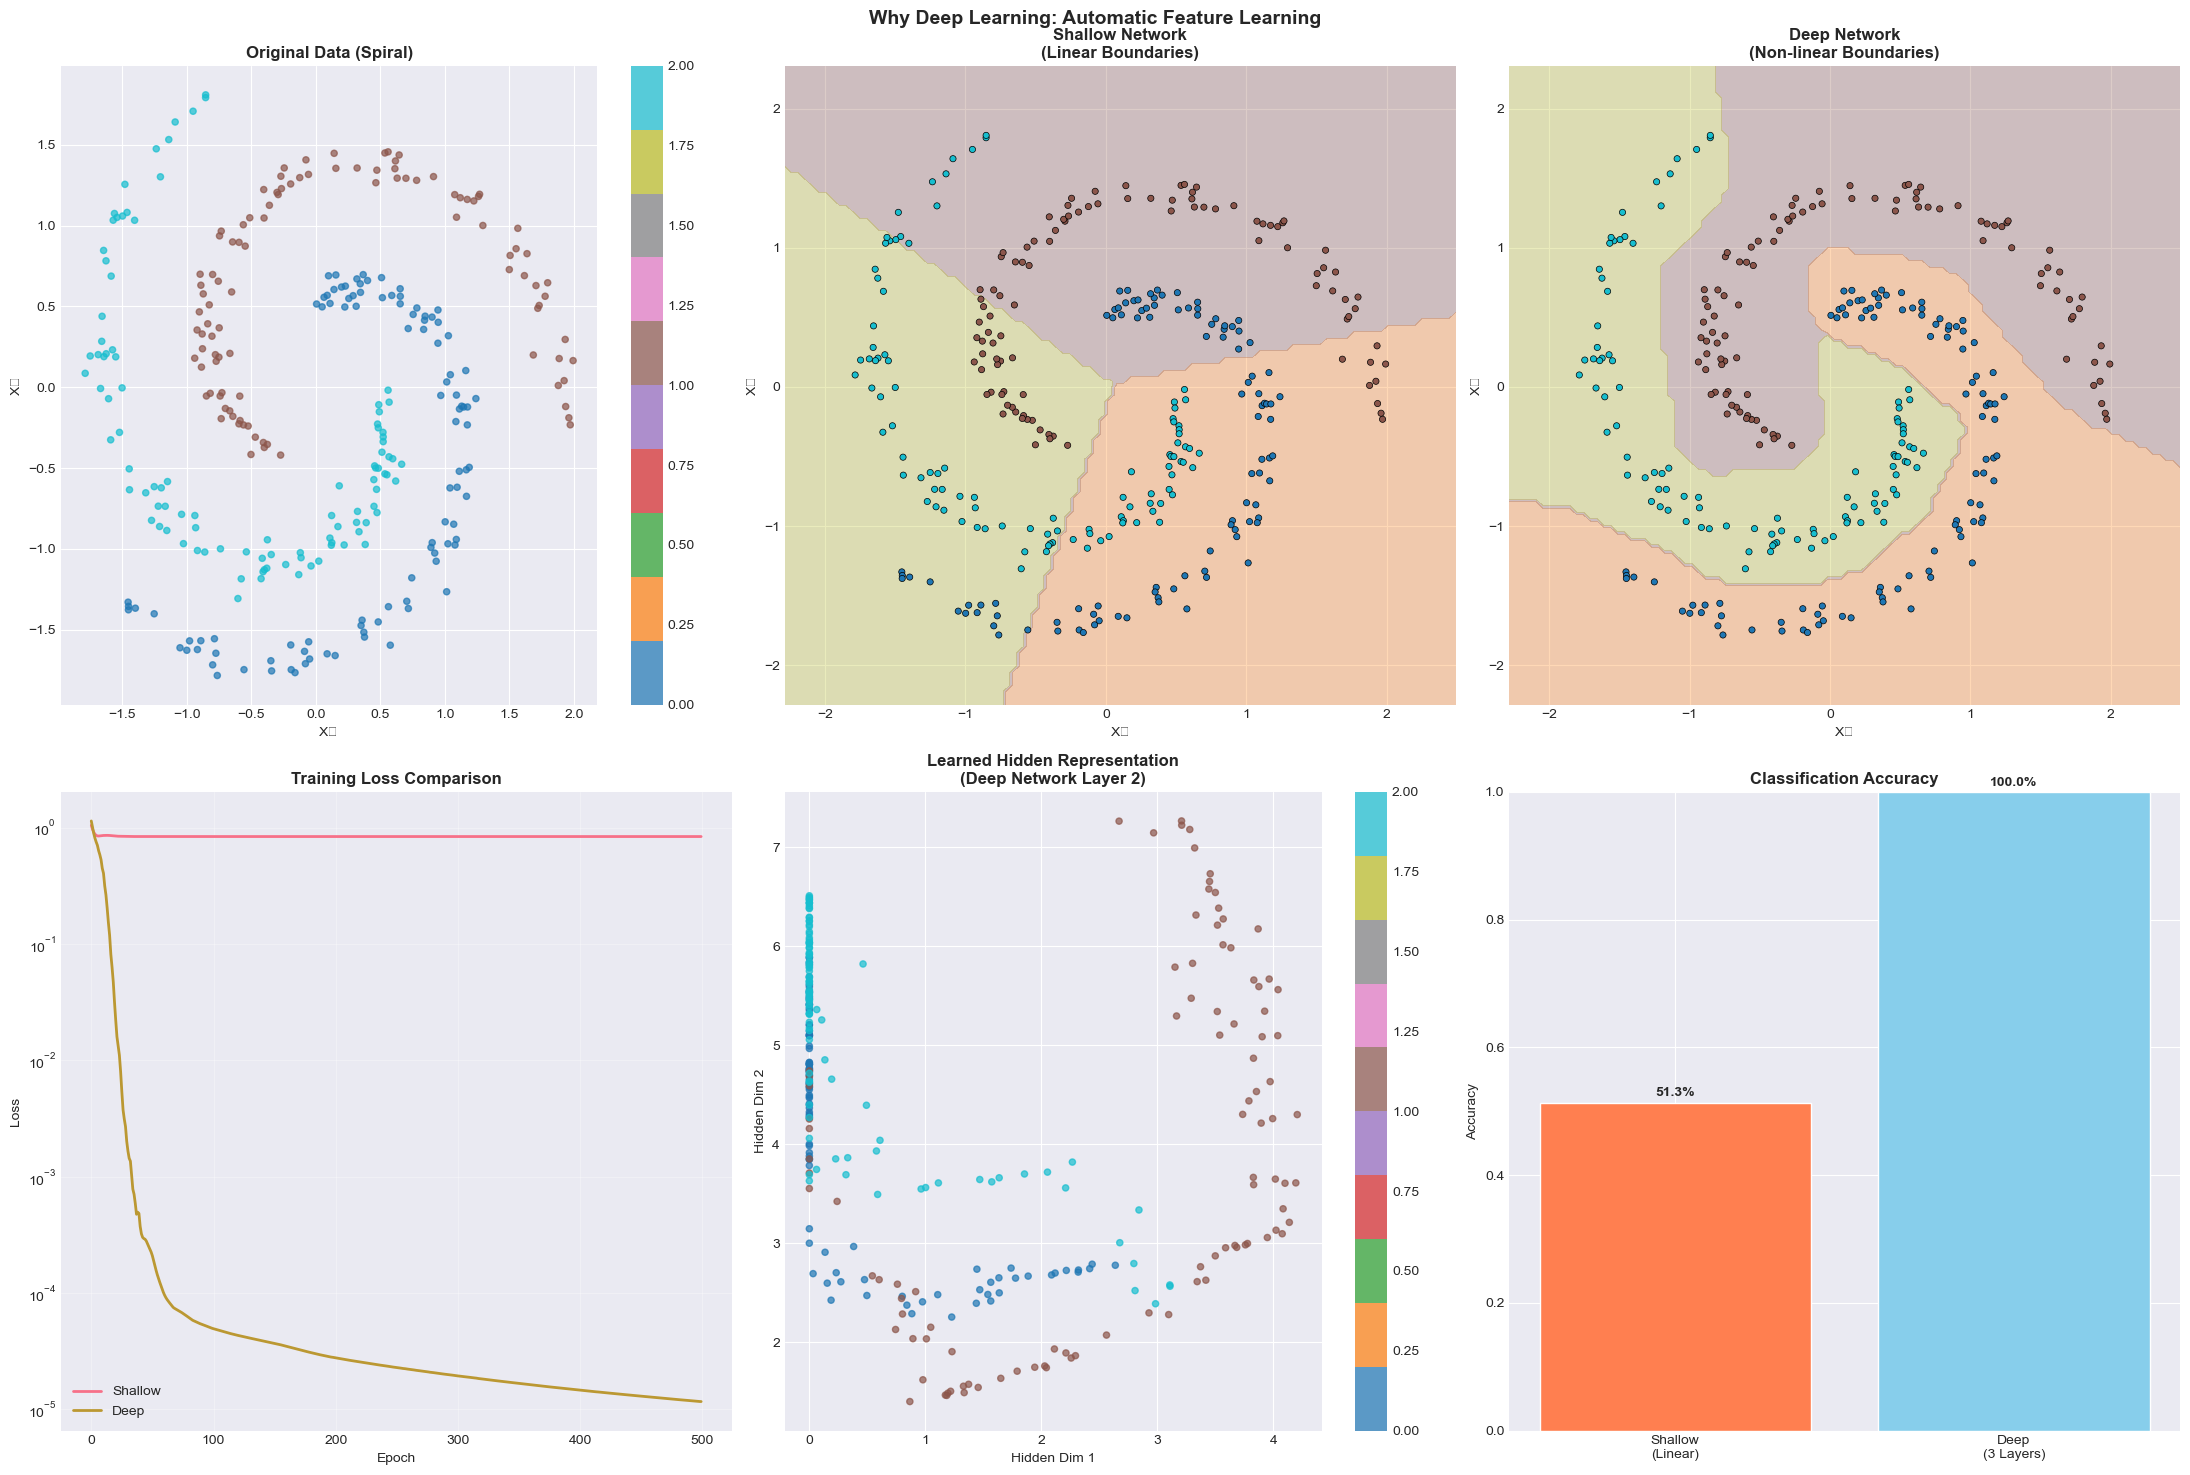


📊 Results:
Shallow network accuracy: 51.3%
Deep network accuracy: 100.0%

💡 Key insight: Deep networks learn to transform the data into a representation
   where linear separation becomes possible!


In [6]:
demo_representation_learning()


In [7]:
# %% [markdown]
# info capacity and Optimization - Width Effects

# %%
def demo_capacity_optimization():
    """
    info demonstrate how network width affects optimization and capacity
    """

    # info generate regression task
    np.random.seed(42)
    X = np.linspace(-3, 3, 100).reshape(-1, 1)
    y_true = np.sin(2 * X).ravel() + 0.1 * np.random.randn(100)

    # info networks of different widths
    widths = [2, 10, 100, 500]

    class FlexibleNet(nn.Module):
        def __init__(self, width):
            super().__init__()
            self.fc1 = nn.Linear(1, width)
            self.fc2 = nn.Linear(width, width)
            self.fc3 = nn.Linear(width, 1)
            self.width = width

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            return self.fc3(x).squeeze()

    # info train networks
    results = {}

    for width in widths:
        print(f"Training network with width {width}...")
        model = FlexibleNet(width)

        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y_true)

        optimizer = optim.Adam(model.parameters(), lr=0.01)

        losses = []
        for epoch in range(1000):
            pred = model(X_tensor)
            loss = F.mse_loss(pred, y_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        results[width] = {
            'model': model,
            'losses': losses,
            'final_loss': losses[-1],
            'n_params': sum(p.numel() for p in model.parameters())
        }

    # info visualization
    fig, axes = plt.subplots(2, 3, figsize=(22, 15))

    # Plot fits for different widths
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(widths)))

    for idx, (width, color) in enumerate(zip(widths[:4], colors)):
        ax = axes[idx // 2, idx % 2]

        model = results[width]['model']
        with torch.no_grad():
            X_test = torch.FloatTensor(X)
            y_pred = model(X_test).numpy()

        ax.scatter(X, y_true, alpha=0.3, s=10, label='Data')
        ax.plot(X, y_pred, color=color, linewidth=2, label=f'Width {width}')
        ax.plot(X, np.sin(2 * X), 'k--', alpha=0.3, label='True function')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Width = {width} ({results[width]["n_params"]} params)',
                    fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # info training curves comparison
    ax = axes[0, 2]
    for width, color in zip(widths, colors):
        ax.plot(results[width]['losses'], label=f'Width {width}',
               color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (log scale)')
    ax.set_title('Training Loss vs Width', fontweight='bold')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # info final loss vs parameters
    ax = axes[1, 2]
    params_list = [results[w]['n_params'] for w in widths]
    losses_list = [results[w]['final_loss'] for w in widths]

    ax.scatter(params_list, losses_list, s=100, c=colors, edgecolors='black')
    ax.plot(params_list, losses_list, 'k--', alpha=0.3)

    for w, p, l in zip(widths, params_list, losses_list):
        ax.annotate(f'w={w}', (p, l), xytext=(5, 5),
                   textcoords='offset points', fontsize=9)

    ax.set_xlabel('Number of Parameters')
    ax.set_ylabel('Final Loss')
    ax.set_title('Optimization Quality vs Model Size', fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    plt.suptitle('Capacity and Optimization: Wider Networks Train Better',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n Summary:")
    for width in widths:
        print(f"Width {width:3d}: {results[width]['n_params']:5d} params, "
              f"Final loss: {results[width]['final_loss']:.4f}")
    print("1. Wider networks achieve lower training loss")
    print("2. More parameters = smoother optimization")
    print("3. Overparameterization helps, not hurts!")


Training network with width 2...
Training network with width 10...
Training network with width 100...
Training network with width 500...


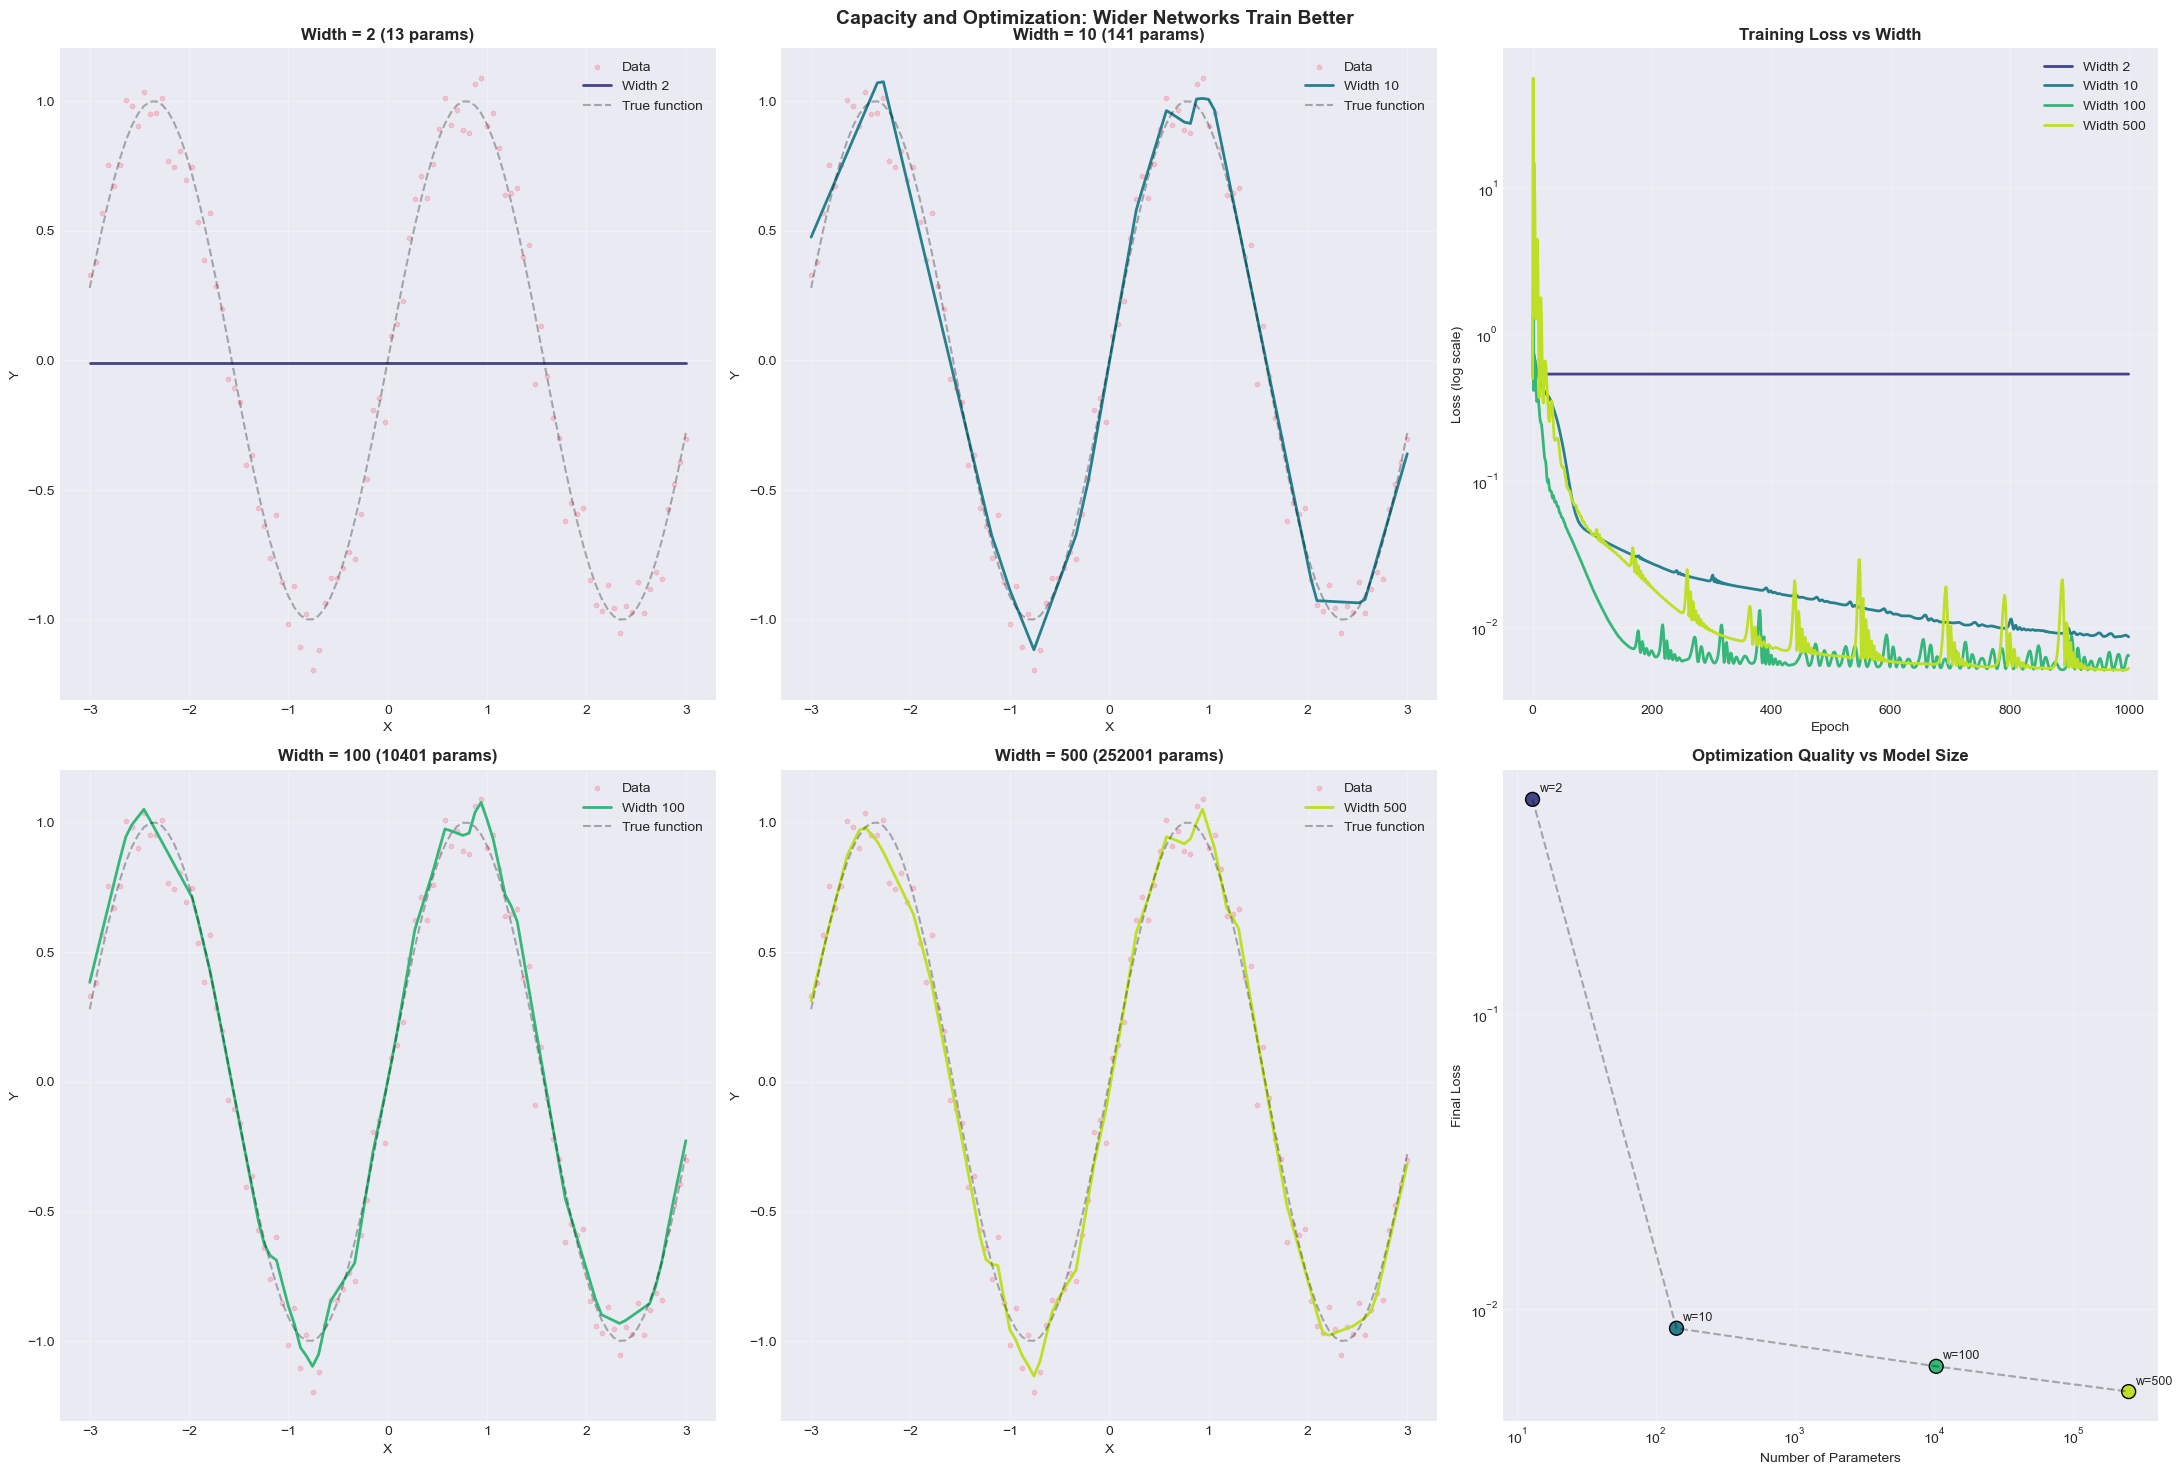


📊 Summary:
Width   2:    13 params, Final loss: 0.5359
Width  10:   141 params, Final loss: 0.0086
Width 100: 10401 params, Final loss: 0.0064
Width 500: 252001 params, Final loss: 0.0053

💡 Key insights:
1. Wider networks achieve lower training loss
2. More parameters = smoother optimization
3. Overparameterization helps, not hurts!


In [9]:
demo_capacity_optimization()


In [11]:
# %% [markdown]
# info foundation Models

# %%
def demo_foundation_models():
    """
    info simulate foundation model behavior: one model, many tasks
    """

    # Simulate a pre-trained "foundation model" with learned representations
    class FoundationModel(nn.Module):
        def __init__(self, input_dim=10, hidden_dim=128):
            super().__init__()
            # info pre-trained backbone (frozen)
            self.backbone = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )

            # info initialize with "pre-trained" weights
            for layer in self.backbone:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_normal_(layer.weight)

            self.freeze_backbone()

        def freeze_backbone(self):
            for param in self.backbone.parameters():
                param.requires_grad = False

        def unfreeze_backbone(self):
            for param in self.backbone.parameters():
                param.requires_grad = True

        def get_features(self, x):
            return self.backbone(x)

    # info different downstream tasks (heads)
    class TaskHead(nn.Module):
        def __init__(self, foundation_model, output_dim):
            super().__init__()
            self.foundation = foundation_model
            self.head = nn.Linear(128, output_dim)

        def forward(self, x):
            features = self.foundation.get_features(x)
            return self.head(features)

    # info generate synthetic multi-task data
    np.random.seed(42)
    n_samples = 200
    X_base = np.random.randn(n_samples, 10).astype(np.float32)

    # info task 1: Binary classification
    y_task1 = (X_base[:, 0] + X_base[:, 1] > 0).astype(int)

    # info task 2: Multi-class classification (3 classes)
    y_task2 = np.digitize(X_base[:, 2] + X_base[:, 3], [-0.5, 0.5]).astype(int)

    # info task 3: Regression
    y_task3 = (2 * X_base[:, 4] - X_base[:, 5] + 0.5 * np.random.randn(n_samples)).astype(np.float32)

    # info train different approaches
    print("Training different approaches...")

    # info approach 1: Separate models from scratch
    def train_from_scratch(X, y, output_dim, task_type='classification'):
        model = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

        optimizer = optim.Adam(model.parameters(), lr=0.01)
        X_tensor = torch.FloatTensor(X)

        if task_type == 'classification':
            y_tensor = torch.LongTensor(y)
            loss_fn = nn.CrossEntropyLoss()
        else:
            y_tensor = torch.FloatTensor(y)
            loss_fn = nn.MSELoss()

        losses = []
        for _ in range(100):
            if task_type == 'classification':
                pred = model(X_tensor)
            else:
                pred = model(X_tensor).squeeze()

            loss = loss_fn(pred, y_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        return model, losses

    # info approach 2: Foundation model + task heads
    foundation = FoundationModel()

    def train_with_foundation(foundation, X, y, output_dim, task_type='classification'):
        task_model = TaskHead(foundation, output_dim)

        # Only train the head
        optimizer = optim.Adam(task_model.head.parameters(), lr=0.01)
        X_tensor = torch.FloatTensor(X)

        if task_type == 'classification':
            y_tensor = torch.LongTensor(y)
            loss_fn = nn.CrossEntropyLoss()
        else:
            y_tensor = torch.FloatTensor(y)
            loss_fn = nn.MSELoss()

        losses = []
        for _ in range(100):
            if task_type == 'classification':
                pred = task_model(X_tensor)
            else:
                pred = task_model(X_tensor).squeeze()

            loss = loss_fn(pred, y_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        return task_model, losses

    # info train all tasks both ways
    scratch_results = {}
    foundation_results = {}

    tasks = [
        ('Task 1 (Binary)', y_task1, 2, 'classification'),
        ('Task 2 (3-Class)', y_task2, 3, 'classification'),
        ('Task 3 (Regression)', y_task3, 1, 'regression')
    ]

    for task_name, y, output_dim, task_type in tasks:
        print(f"  Training {task_name}...")
        scratch_model, scratch_losses = train_from_scratch(X_base, y, output_dim, task_type)
        foundation_model, foundation_losses = train_with_foundation(foundation, X_base, y, output_dim, task_type)

        scratch_results[task_name] = scratch_losses
        foundation_results[task_name] = foundation_losses

    # info visualization
    fig, axes = plt.subplots(2, 3, figsize=(22, 15))

    # info training curves for each task
    for idx, (task_name, _, _, _) in enumerate(tasks):
        ax = axes[0, idx]
        ax.plot(scratch_results[task_name], label='From Scratch', linewidth=2)
        ax.plot(foundation_results[task_name], label='Foundation Model', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(task_name, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

    # info parameter count comparison
    ax = axes[1, 0]

    # info calculate parameters
    scratch_params = sum(p.numel() for p in scratch_model.parameters())
    foundation_shared_params = sum(p.numel() for p in foundation.backbone.parameters())
    head_params = 128 * 2 + 2  # One task head

    # info bar plot
    categories = ['3 Separate\nModels', 'Foundation\n+ 3 Heads']
    total_params = [scratch_params * 3, foundation_shared_params + head_params * 3]

    bars = ax.bar(categories, total_params, color=['coral', 'skyblue'])
    ax.set_ylabel('Total Parameters')
    ax.set_title('Parameter Efficiency', fontweight='bold')

    for bar, val in zip(bars, total_params):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                f'{val:,}', ha='center', fontweight='bold')

    # info convergence speed
    ax = axes[1, 1]

    # info find epochs to convergence (loss < threshold)
    def find_convergence(losses, threshold=0.1):
        for i, loss in enumerate(losses):
            if loss < threshold:
                return i
        return len(losses)

    task_names_short = ['Binary', '3-Class', 'Regression']
    scratch_conv = [find_convergence(scratch_results[t[0]], 0.5) for t in tasks]
    foundation_conv = [find_convergence(foundation_results[t[0]], 0.5) for t in tasks]

    x_pos = np.arange(len(task_names_short))
    width = 0.35

    ax.bar(x_pos - width/2, scratch_conv, width, label='From Scratch', color='coral')
    ax.bar(x_pos + width/2, foundation_conv, width, label='Foundation', color='skyblue')

    ax.set_xlabel('Task')
    ax.set_ylabel('Epochs to Convergence')
    ax.set_title('Training Speed', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(task_names_short)
    ax.legend()

    # info conceptual diagram
    ax = axes[1, 2]
    ax.text(0.5, 0.8, 'Foundation Model Paradigm', fontsize=14, fontweight='bold', ha='center')
    ax.text(0.5, 0.6, 'One Model → Many Tasks', fontsize=12, ha='center')
    ax.text(0.5, 0.4, '✓ Shared representations', fontsize=10, ha='center')
    ax.text(0.5, 0.3, '✓ Transfer learning', fontsize=10, ha='center')
    ax.text(0.5, 0.2, '✓ Parameter efficient', fontsize=10, ha='center')
    ax.text(0.5, 0.1, '✓ Fast adaptation', fontsize=10, ha='center')
    ax.axis('off')

    plt.suptitle('Foundation Models: One Model, Many Tasks', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n Key insights:")
    print("1. Foundation models converge faster (transfer learning)")
    print("2. Dramatically fewer parameters (shared backbone)")
    print("3. Better performance with less data")
    print("4. This is how GPT, BERT, CLIP work!")


Training different approaches...
  Training Task 1 (Binary)...
  Training Task 2 (3-Class)...
  Training Task 3 (Regression)...


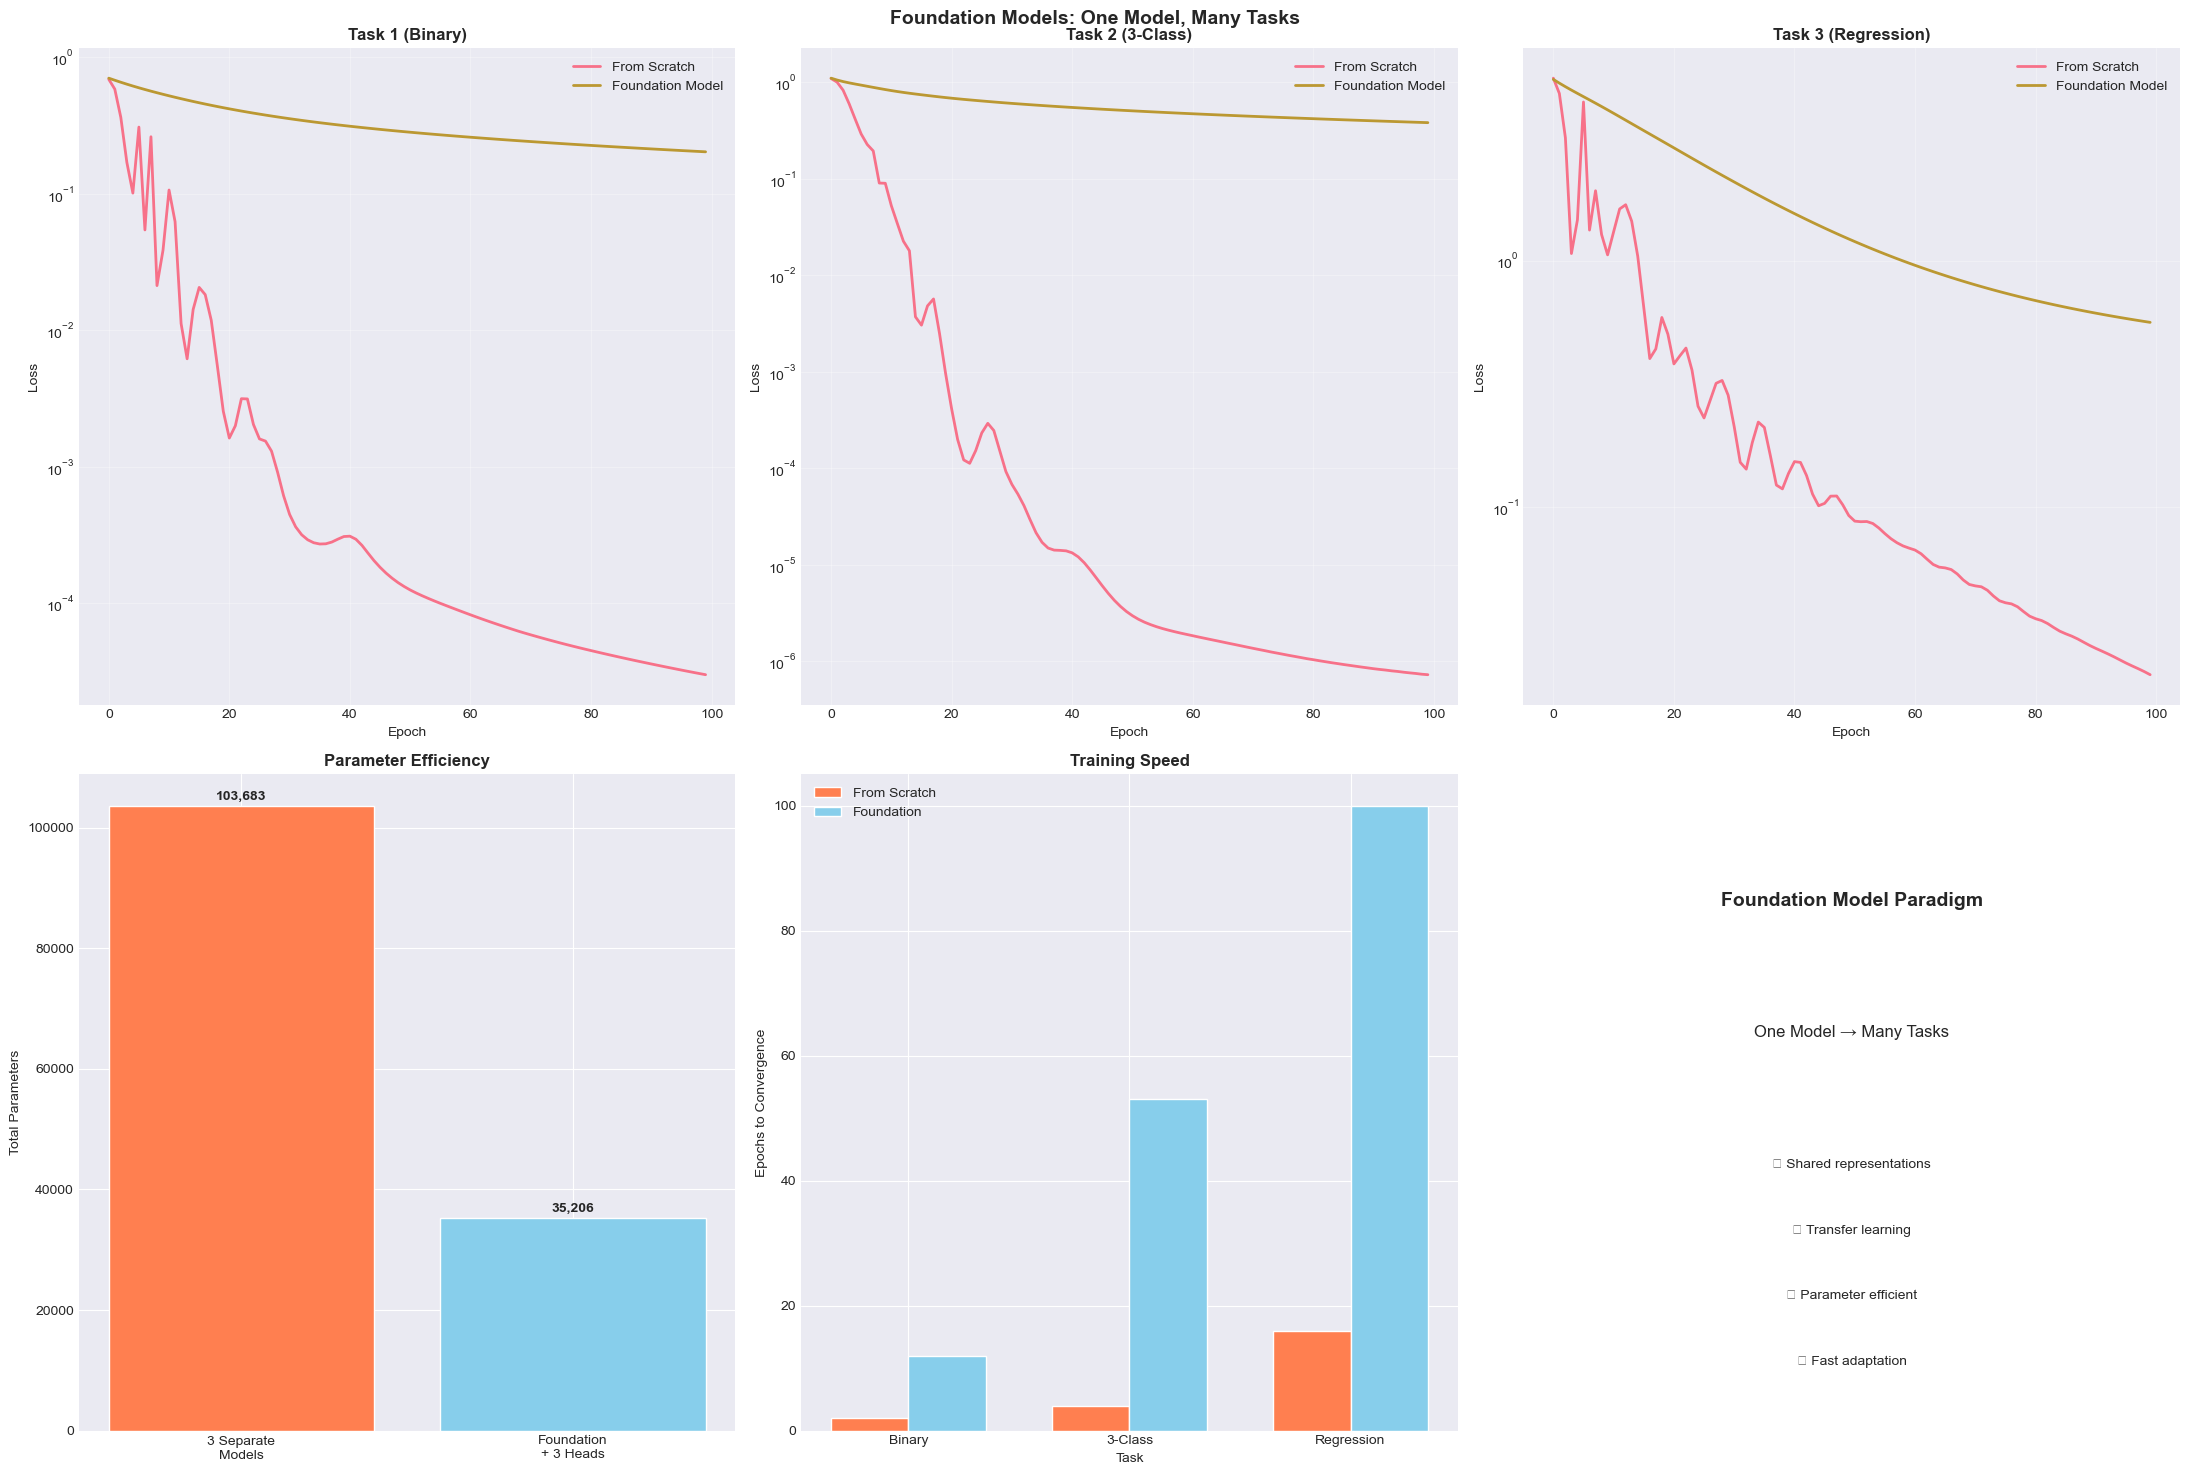


💡 Key insights:
1. Foundation models converge faster (transfer learning)
2. Dramatically fewer parameters (shared backbone)
3. Better performance with less data
4. This is how GPT, BERT, CLIP work!


In [12]:
demo_foundation_models()


In [13]:
# %% [markdown]
# info modern Optimizers - Adam vs SGD

# %%
def demo_modern_optimizers():
    """
    info compare different optimizers on challenging optimization problems
    """

    # info create a challenging 2D optimization problem
    def create_loss_landscape(type='ravine'):
        if type == 'ravine':
            # info rosenbrock function (narrow valley)
            def loss_fn(params):
                x, y = params[0], params[1]
                return (1 - x)**2 + 100 * (y - x**2)**2
        elif type == 'saddle':
            # info saddle point
            def loss_fn(params):
                x, y = params[0], params[1]
                return x**2 - y**2 + 0.1 * (x**2 + y**2)
        else:  # noisy
            # info noisy surface
            def loss_fn(params):
                x, y = params[0], params[1]
                base = (x**2 + y**2)
                noise = 0.5 * torch.sin(10*x) * torch.cos(10*y)
                return base + noise

        return loss_fn

    # info optimizers to compare
    def get_optimizers(params):
        return {
            'SGD': optim.SGD([params], lr=0.001),
            'SGD+Momentum': optim.SGD([params], lr=0.001, momentum=0.9),
            'Adam': optim.Adam([params], lr=0.01),
            'RMSprop': optim.RMSprop([params], lr=0.01),
            'AdamW': optim.AdamW([params], lr=0.01, weight_decay=0.01)
        }

    # info run optimization
    problems = ['ravine', 'saddle', 'noisy']

    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.25)

    for prob_idx, problem_type in enumerate(problems):
        loss_fn = create_loss_landscape(problem_type)

        # info create contour plot background
        x = torch.linspace(-2, 2, 100)
        y = torch.linspace(-2, 2, 100)
        X, Y = torch.meshgrid(x, y, indexing='xy')
        Z = torch.zeros_like(X)

        for i in range(100):
            for j in range(100):
                Z[i, j] = loss_fn(torch.tensor([X[i, j], Y[i, j]]))

        # info plot landscape
        ax_landscape = fig.add_subplot(gs[prob_idx, 0])
        contour = ax_landscape.contour(X, Y, Z, levels=30, alpha=0.4, cmap='viridis')
        ax_landscape.set_title(f'{problem_type.capitalize()} Landscape', fontweight='bold')
        ax_landscape.set_xlabel('θ₁')
        ax_landscape.set_ylabel('θ₂')

        # info track optimization paths
        results = {}

        for opt_name, color in zip(['SGD', 'Adam', 'AdamW'], ['red', 'blue', 'green']):
            # info initialize parameters
            if problem_type == 'ravine':
                init_params = torch.tensor([-1.5, 1.5], requires_grad=True)
            else:
                init_params = torch.tensor([1.5, 1.5], requires_grad=True)

            params = nn.Parameter(init_params.clone())
            optimizer = get_optimizers(params)[opt_name]

            trajectory = [params.detach().clone().numpy()]
            losses = []

            # info optimize
            for step in range(200):
                loss = loss_fn(params)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                trajectory.append(params.detach().clone().numpy())
                losses.append(loss.item())

            results[opt_name] = {
                'trajectory': np.array(trajectory),
                'losses': losses
            }

            # info plot trajectory
            traj = np.array(trajectory)
            ax_landscape.plot(traj[:, 0], traj[:, 1],
                             color=color, alpha=0.7, linewidth=2,
                             label=opt_name)
            ax_landscape.scatter(traj[0, 0], traj[0, 1],
                                color=color, s=100, marker='o',
                                edgecolors='black', linewidth=2)
            ax_landscape.scatter(traj[-1, 0], traj[-1, 1],
                                color=color, s=100, marker='*',
                                edgecolors='black', linewidth=2)

        ax_landscape.legend(fontsize=9)
        ax_landscape.set_xlim(-2, 2)
        ax_landscape.set_ylim(-2, 2)

        # info loss curves
        ax_loss = fig.add_subplot(gs[prob_idx, 1])
        for opt_name, color in zip(['SGD', 'Adam', 'AdamW'], ['red', 'blue', 'green']):
            ax_loss.plot(results[opt_name]['losses'],
                        color=color, linewidth=2, label=opt_name)

        ax_loss.set_xlabel('Step')
        ax_loss.set_ylabel('Loss')
        ax_loss.set_title(f'Convergence ({problem_type})', fontweight='bold')
        ax_loss.set_yscale('log')
        ax_loss.legend(fontsize=9)
        ax_loss.grid(True, alpha=0.3)

        # info step sizes (effective learning rates)
        if prob_idx == 0:  # Only show for first problem
            ax_lr = fig.add_subplot(gs[prob_idx, 2])

            # info simulate effective learning rates
            steps = np.arange(200)
            sgd_lr = np.ones(200) * 0.001
            adam_lr = 0.01 * np.sqrt(1 - 0.999**steps) / (1 - 0.9**steps)

            ax_lr.plot(steps, sgd_lr, 'red', linewidth=2, label='SGD (fixed)')
            ax_lr.plot(steps, adam_lr, 'blue', linewidth=2, label='Adam (adaptive)')
            ax_lr.set_xlabel('Step')
            ax_lr.set_ylabel('Effective LR')
            ax_lr.set_title('Learning Rate Schedule', fontweight='bold')
            ax_lr.legend()
            ax_lr.grid(True, alpha=0.3)

    # info Adam internal state visualization
    ax_adam = fig.add_subplot(gs[:, 3])

    # info simulate Adam's momentum and variance
    grad_history = np.sin(np.linspace(0, 4*np.pi, 100)) + 0.5 * np.random.randn(100)

    m = np.zeros(100)
    v = np.zeros(100)
    beta1, beta2 = 0.9, 0.999

    for t in range(1, 100):
        m[t] = beta1 * m[t-1] + (1 - beta1) * grad_history[t]
        v[t] = beta2 * v[t-1] + (1 - beta2) * grad_history[t]**2

    ax_adam.plot(grad_history[:50], 'gray', alpha=0.5, label='Gradient', linewidth=1)
    ax_adam.plot(m[:50], 'blue', label='Momentum (m)', linewidth=2)
    ax_adam.plot(np.sqrt(v[:50]), 'red', label='√Variance (√v)', linewidth=2)

    ax_adam.set_xlabel('Step')
    ax_adam.set_ylabel('Value')
    ax_adam.set_title('Adam Internal States', fontweight='bold', fontsize=12)
    ax_adam.legend()
    ax_adam.grid(True, alpha=0.3)

    plt.suptitle('Modern Optimizers: Adaptive Learning Beats Fixed Rates',
                fontsize=14, fontweight='bold')
    plt.show()

    print("\n💡 Key insights from the visualization:")
    print("1. SGD struggles with ravines (zigzag pattern)")
    print("2. Adam adapts to the landscape geometry")
    print("3. Momentum helps but isn't enough for complex landscapes")
    print("4. AdamW (Adam + weight decay) often performs best")


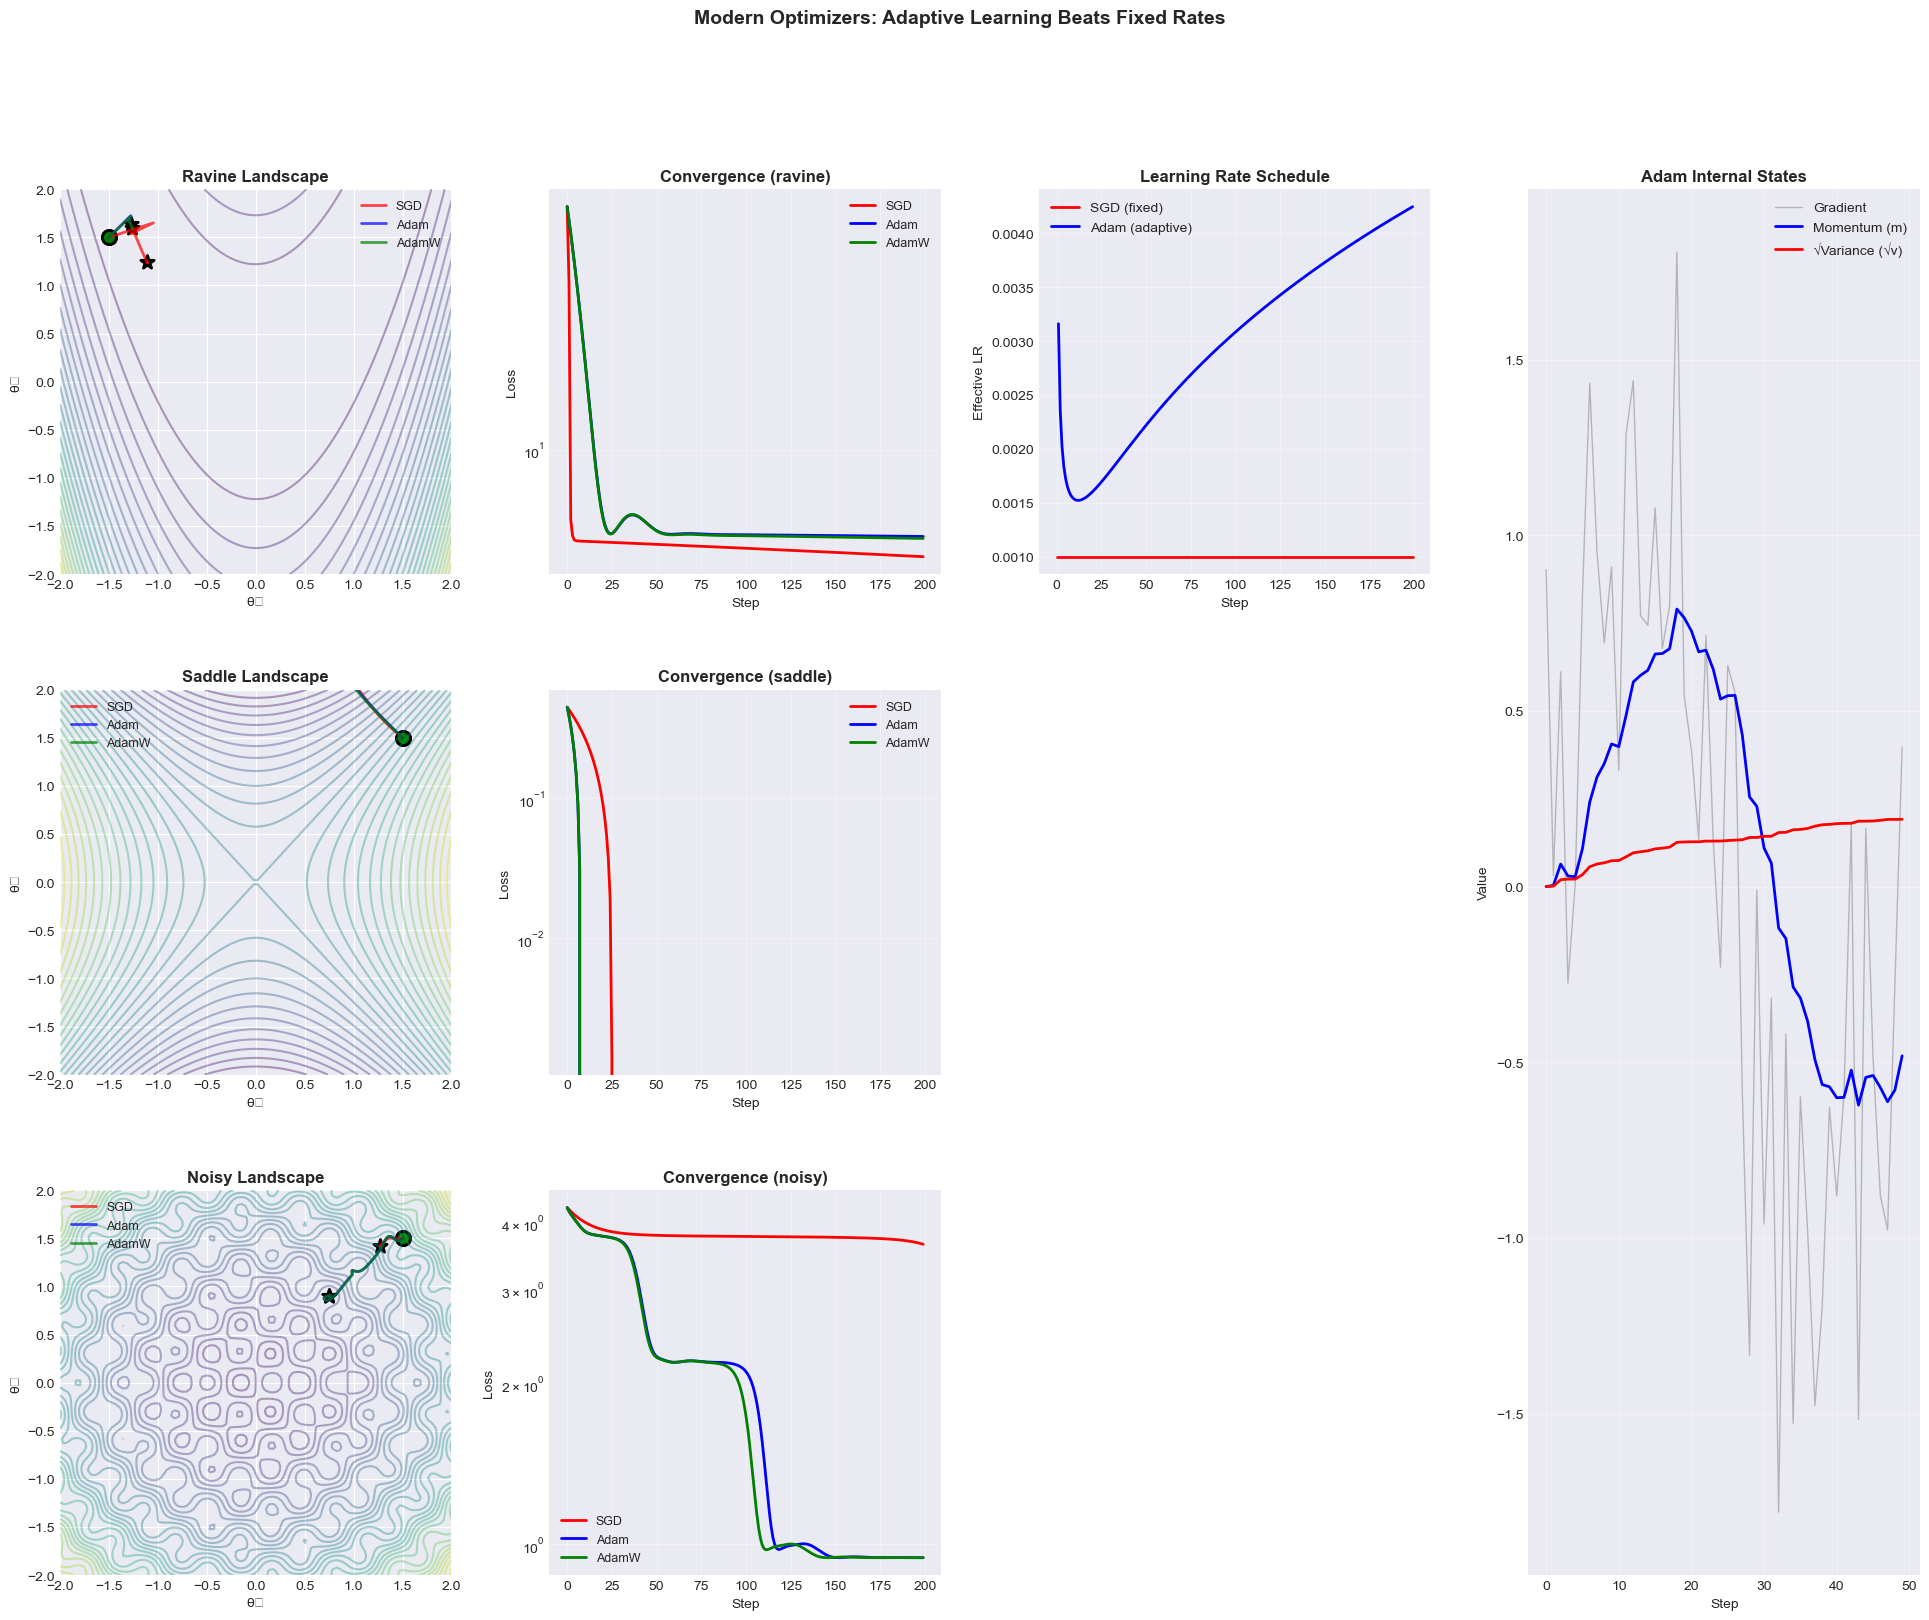


💡 Key insights from the visualization:
1. SGD struggles with ravines (zigzag pattern)
2. Adam adapts to the landscape geometry
3. Momentum helps but isn't enough for complex landscapes
4. AdamW (Adam + weight decay) often performs best


In [14]:
demo_modern_optimizers()


In [15]:
# %% [markdown]
# info Generalization - Memorization vs Learning

# %%
def demo_generalization():
    """
    info demonstrate the difference between memorization and generalization
    """

    # Create dataset
    np.random.seed(42)
    n_train = 50
    n_test = 50

    # info generate polynomial + noise
    X_train = np.random.uniform(-3, 3, n_train).reshape(-1, 1)
    X_test = np.random.uniform(-3, 3, n_test).reshape(-1, 1)

    # info true function: simple polynomial
    def true_function(x):
        return 0.5 * x**2 - 2 * x + 1

    y_train_clean = true_function(X_train).ravel()
    y_test = true_function(X_test).ravel() + 0.3 * np.random.randn(n_test)

    # info create two training scenarios
    # 1. info clean labels (should generalize)
    y_train_clean = y_train_clean + 0.3 * np.random.randn(n_train)

    # 2. info random labels (will memorize)
    y_train_random = np.random.randn(n_train) * 2

    # info different model complexities
    class PolynomialModel(nn.Module):
        def __init__(self, degree):
            super().__init__()
            self.degree = degree
            self.coeffs = nn.Parameter(torch.randn(degree + 1))

        def forward(self, x):
            result = torch.zeros_like(x).squeeze()
            for i, coeff in enumerate(self.coeffs):
                result += coeff * (x.squeeze() ** i)
            return result

    class DeepModel(nn.Module):
        def __init__(self, width=100):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(1, width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.ReLU(),
                nn.Linear(width, 1)
            )

        def forward(self, x):
            return self.net(x).squeeze()

    # info train models
    def train_model(model, X, y, epochs=1000):
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test)

        train_losses = []
        test_losses = []

        for epoch in range(epochs):
            # info train
            pred_train = model(X_tensor)
            train_loss = F.mse_loss(pred_train, y_tensor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # info test
            with torch.no_grad():
                pred_test = model(X_test_tensor)
                test_loss = F.mse_loss(pred_test, y_test_tensor)

            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())

        return train_losses, test_losses

    print("Training models...")

    # info scenario 1: clean labels
    simple_clean = PolynomialModel(degree=2)
    complex_clean = DeepModel(width=100)

    simple_clean_train, simple_clean_test = train_model(simple_clean, X_train, y_train_clean)
    complex_clean_train, complex_clean_test = train_model(complex_clean, X_train, y_train_clean)

    # info scenario 2: random labels
    simple_random = PolynomialModel(degree=2)
    complex_random = DeepModel(width=100)

    simple_random_train, simple_random_test = train_model(simple_random, X_train, y_train_random)
    complex_random_train, complex_random_test = train_model(complex_random, X_train, y_train_random)

    # info visualization
    fig, axes = plt.subplots(2, 3, figsize=(22, 15))

    # info plot fits - info clean labels
    ax = axes[0, 0]
    X_plot = np.linspace(-3.5, 3.5, 200).reshape(-1, 1)
    X_plot_tensor = torch.FloatTensor(X_plot)

    ax.scatter(X_train, y_train_clean, alpha=0.5, s=30, label='Train (clean)')
    ax.plot(X_plot, true_function(X_plot), 'k--', alpha=0.5, label='True function')

    with torch.no_grad():
        simple_pred = simple_clean(X_plot_tensor).numpy()
        complex_pred = complex_clean(X_plot_tensor).numpy()

    ax.plot(X_plot, simple_pred, 'blue', linewidth=2, label='Simple model')
    ax.plot(X_plot, complex_pred, 'red', linewidth=2, label='Complex model')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Clean Labels: Both Generalize', fontweight='bold')
    ax.legend()
    ax.set_ylim([-10, 10])
    ax.grid(True, alpha=0.3)

    # info plot fits - random labels
    ax = axes[0, 1]
    ax.scatter(X_train, y_train_random, alpha=0.5, s=30, label='Train (random)')
    ax.plot(X_plot, true_function(X_plot), 'k--', alpha=0.5, label='True function')

    with torch.no_grad():
        simple_pred = simple_random(X_plot_tensor).numpy()
        complex_pred = complex_random(X_plot_tensor).numpy()

    ax.plot(X_plot, simple_pred, 'blue', linewidth=2, label='Simple model')
    ax.plot(X_plot, complex_pred, 'red', linewidth=2, label='Complex model', alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Random Labels: Complex Memorizes', fontweight='bold')
    ax.legend()
    ax.set_ylim([-10, 10])
    ax.grid(True, alpha=0.3)

    # info training curves - clean
    ax = axes[0, 2]
    ax.plot(simple_clean_train, 'blue', linewidth=2, label='Simple train')
    ax.plot(simple_clean_test, 'blue', linewidth=2, linestyle='--', label='Simple test')
    ax.plot(complex_clean_train, 'red', linewidth=2, label='Complex train')
    ax.plot(complex_clean_test, 'red', linewidth=2, linestyle='--', label='Complex test')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Clean Labels: Good Generalization', fontweight='bold')
    ax.set_yscale('log')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # info training curves - random
    ax = axes[1, 0]
    ax.plot(simple_random_train, 'blue', linewidth=2, label='Simple train')
    ax.plot(simple_random_test, 'blue', linewidth=2, linestyle='--', label='Simple test')
    ax.plot(complex_random_train, 'red', linewidth=2, label='Complex train')
    ax.plot(complex_random_test, 'red', linewidth=2, linestyle='--', label='Complex test')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Random Labels: Memorization', fontweight='bold')
    ax.set_yscale('log')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # info generalization gap
    ax = axes[1, 1]

    gap_clean = np.array(complex_clean_test) - np.array(complex_clean_train)
    gap_random = np.array(complex_random_test) - np.array(complex_random_train)

    ax.plot(gap_clean, 'green', linewidth=2, label='Clean labels')
    ax.plot(gap_random, 'orange', linewidth=2, label='Random labels')
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Loss - Train Loss')
    ax.set_title('Generalization Gap', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # info key insights
    ax = axes[1, 2]
    ax.text(0.5, 0.8, 'Key Insights:', fontsize=14, fontweight='bold', ha='center')
    ax.text(0.1, 0.6, '1. Deep networks CAN memorize random labels', fontsize=11)
    ax.text(0.1, 0.45, '2. But prefer to learn patterns when they exist', fontsize=11)
    ax.text(0.1, 0.3, '3. Generalization ≠ inability to memorize', fontsize=11)
    ax.text(0.1, 0.15, '4. SGD implicit bias → simple solutions', fontsize=11)
    ax.axis('off')

    plt.suptitle('Generalization Mystery: Networks Prefer Patterns Over Memorization',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n📊 Final test losses:")
    print(f"Clean labels - Simple: {simple_clean_test[-1]:.3f}, Complex: {complex_clean_test[-1]:.3f}")
    print(f"Random labels - Simple: {simple_random_test[-1]:.3f}, Complex: {complex_random_test[-1]:.3f}")


Training models...


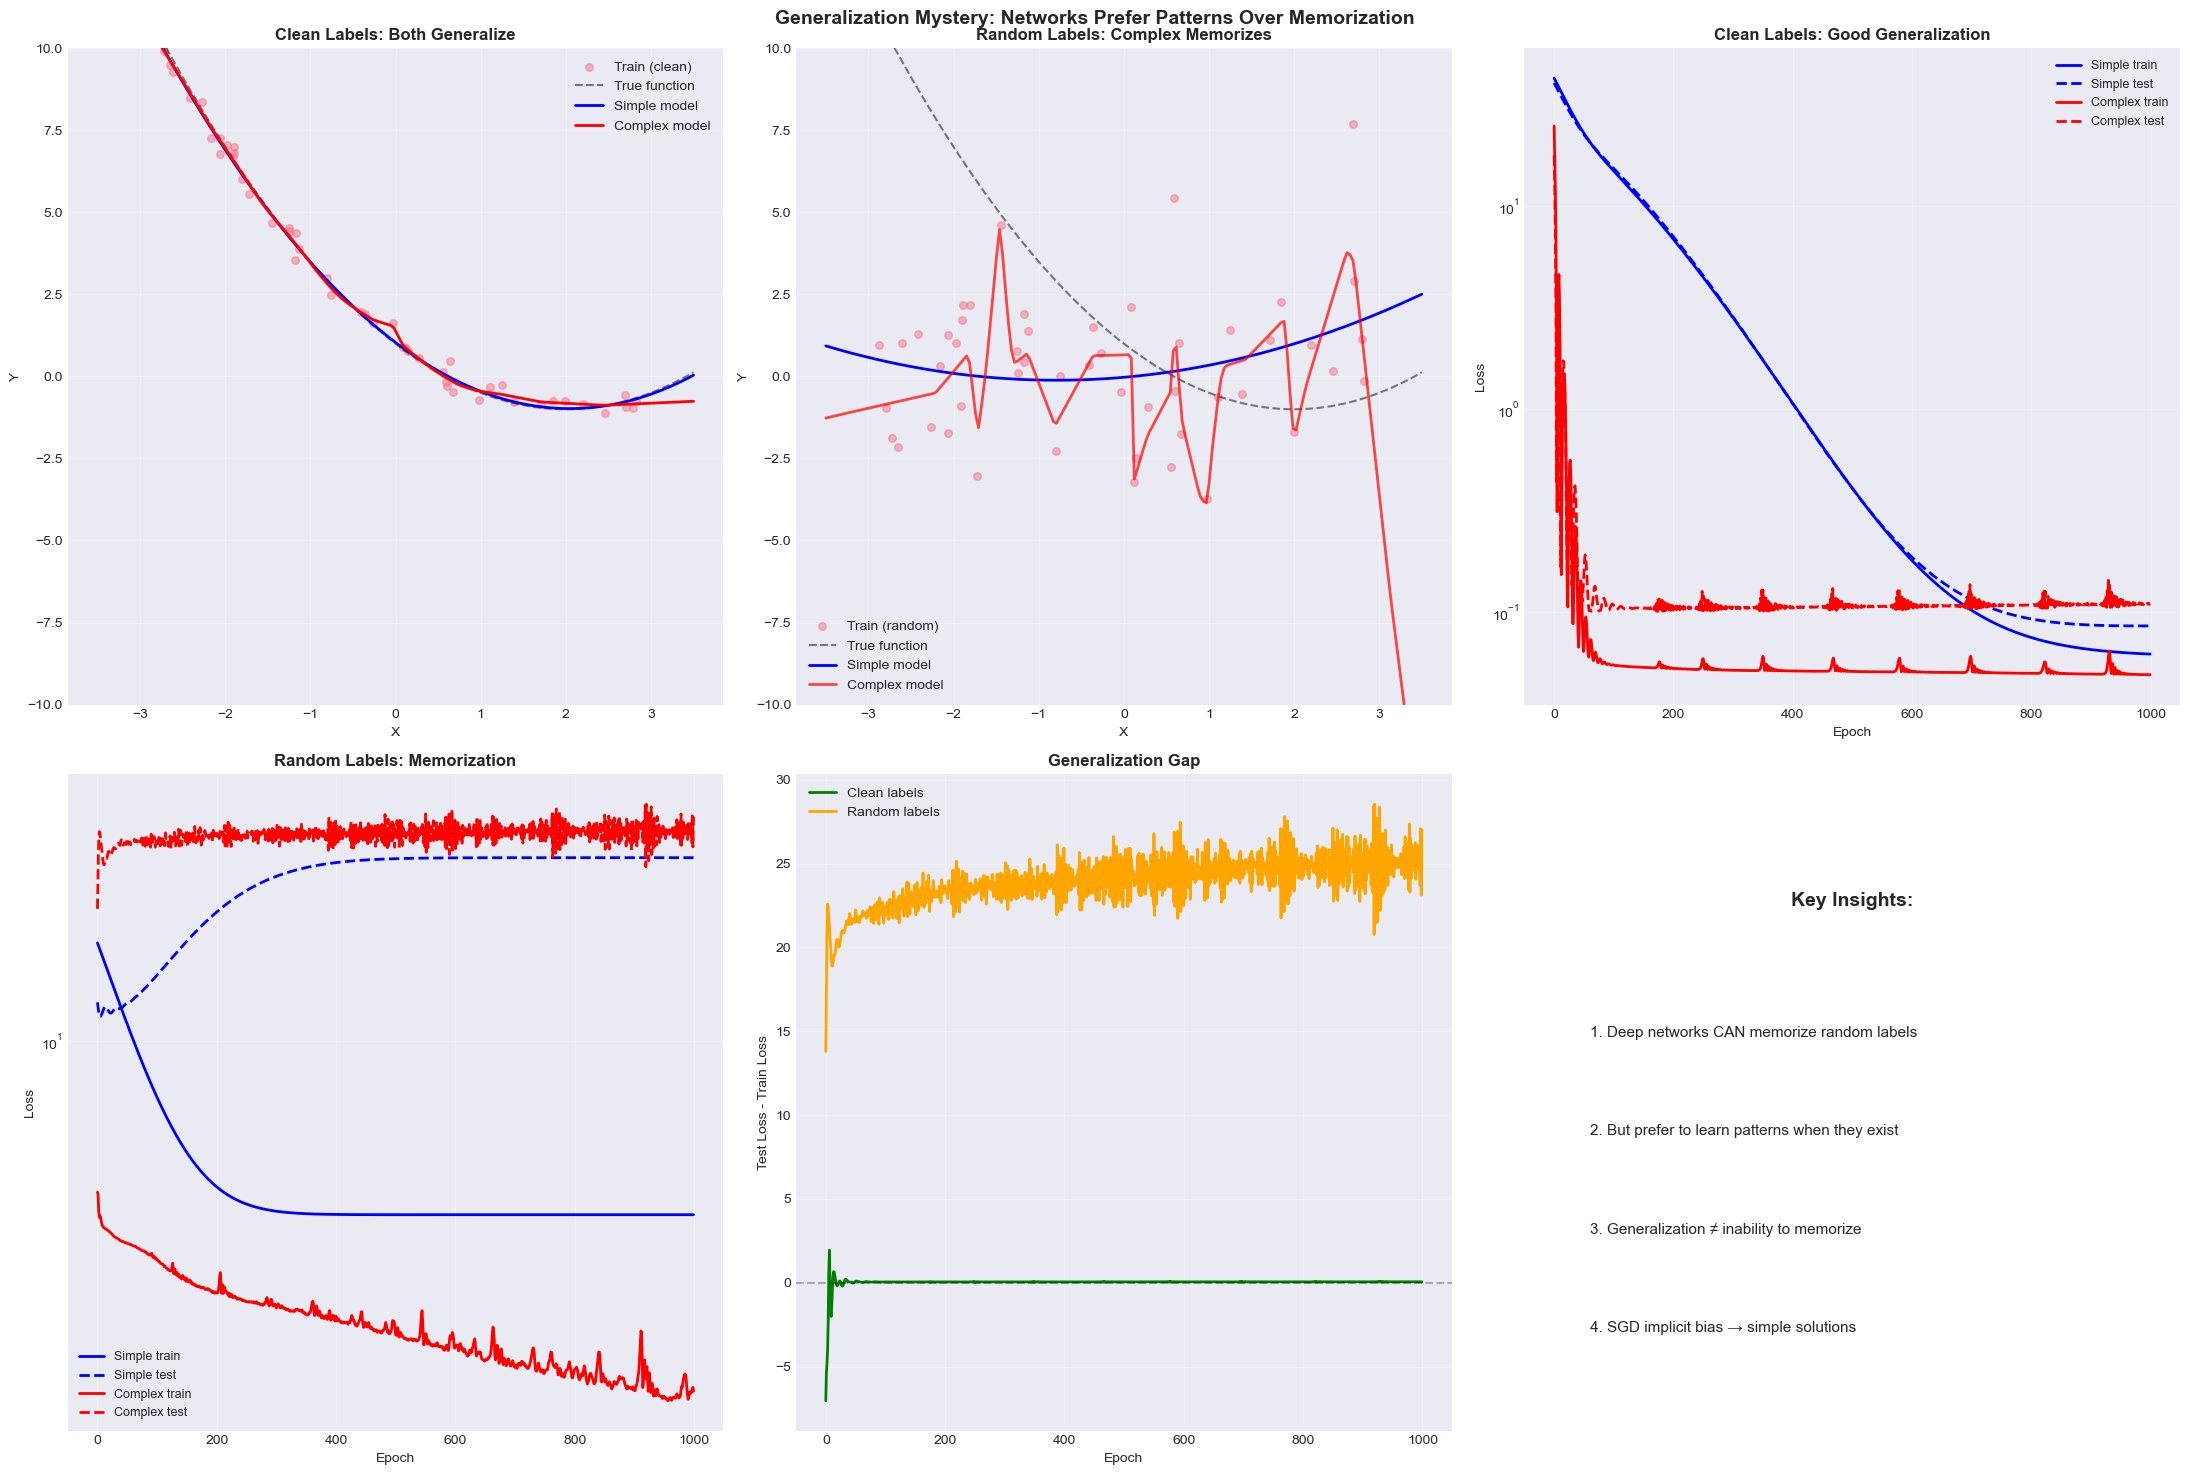


📊 Final test losses:
Clean labels - Simple: 0.085, Complex: 0.110
Random labels - Simple: 23.804, Complex: 28.905


In [16]:
demo_generalization()


In [17]:
# %% [markdown]
# info double descent curve

# %%
def demo_double_descent():
    """
    info demonstrate the double descent phenomenon
    """

    # info generate dataset
    np.random.seed(42)
    n_samples = 30  # Small dataset to see interpolation threshold
    n_features = 20

    # info random features
    X = np.random.randn(n_samples, n_features).astype(np.float32)
    # info linear combination + noise
    true_weights = np.random.randn(n_features)
    y = X @ true_weights + 0.1 * np.random.randn(n_samples)

    # info create test set
    X_test = np.random.randn(100, n_features).astype(np.float32)
    y_test = X_test @ true_weights + 0.1 * np.random.randn(100)

    # info train models of different sizes
    model_sizes = np.logspace(0.5, 3, 30).astype(int)
    model_sizes = np.unique(model_sizes)  # Remove duplicates

    train_losses = []
    test_losses = []

    print("Training models of different sizes...")

    for hidden_size in model_sizes:
        # info define model
        model = nn.Sequential(
            nn.Linear(n_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        # info count parameters
        n_params = sum(p.numel() for p in model.parameters())

        # info train
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y).reshape(-1, 1)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

        # info train until convergence (or max epochs)
        for epoch in range(500):
            pred = model(X_tensor)
            loss = F.mse_loss(pred, y_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if loss.item() < 1e-5:  # Early stopping
                break

        # info final losses
        with torch.no_grad():
            train_loss = F.mse_loss(model(X_tensor), y_tensor).item()
            test_loss = F.mse_loss(model(X_test_tensor), y_test_tensor).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if hidden_size % 10 == 0:
            print(f"  Size {hidden_size}: params={n_params}, test_loss={test_loss:.3f}")

    # info calculate interpolation threshold
    n_data_points = n_samples
    param_counts = [(n_features + 1) * h + (h + 1) for h in model_sizes]

    # info visualization
    fig, axes = plt.subplots(2, 2, figsize=(21, 15))

    # info main double descent curve
    ax = axes[0, 0]
    ax.plot(param_counts, train_losses, 'b-', linewidth=2, label='Train Loss')
    ax.plot(param_counts, test_losses, 'r-', linewidth=2, label='Test Loss')

    # info mark interpolation threshold
    threshold = n_samples
    ax.axvline(threshold, color='green', linestyle='--', linewidth=2,
              alpha=0.7, label='Interpolation Threshold')

    # info shade regions
    ax.axvspan(0, threshold, alpha=0.1, color='orange', label='Under-parameterized')
    ax.axvspan(threshold, max(param_counts), alpha=0.1, color='blue', label='Over-parameterized')

    ax.set_xlabel('Number of Parameters')
    ax.set_ylabel('Loss')
    ax.set_title('Double Descent Curve', fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # info zoom on critical region
    ax = axes[0, 1]

    # info find points near threshold
    near_threshold = [(p, train, test) for p, train, test in zip(param_counts, train_losses, test_losses)
                      if 0.5 * threshold <= p <= 2 * threshold]

    if near_threshold:
        p_near, train_near, test_near = zip(*near_threshold)
        ax.plot(p_near, train_near, 'b-o', linewidth=2, label='Train')
        ax.plot(p_near, test_near, 'r-o', linewidth=2, label='Test')
        ax.axvline(threshold, color='green', linestyle='--', linewidth=2)
        ax.set_xlabel('Number of Parameters')
        ax.set_ylabel('Loss')
        ax.set_title('Zoom: Critical Region', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # info classical view (stopping early)
    ax = axes[1, 0]
    classical_stop = min(15, len(param_counts))
    ax.plot(param_counts[:classical_stop], test_losses[:classical_stop],
           'r-o', linewidth=2)
    ax.set_xlabel('Number of Parameters')
    ax.set_ylabel('Test Loss')
    ax.set_title('Classical View (U-Curve)', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # info model capacity illustration
    ax = axes[1, 1]

    # info bar plot of train vs test at different points
    selected_sizes = [5, 15, 25]  # Indices
    selected_params = [param_counts[i] for i in selected_sizes]
    selected_train = [train_losses[i] for i in selected_sizes]
    selected_test = [test_losses[i] for i in selected_sizes]

    x_pos = np.arange(len(selected_sizes))
    width = 0.35

    bars1 = ax.bar(x_pos - width/2, selected_train, width, label='Train', color='blue')
    bars2 = ax.bar(x_pos + width/2, selected_test, width, label='Test', color='red')

    ax.set_xlabel('Model Size')
    ax.set_ylabel('Loss')
    ax.set_title('Train vs Test at Different Capacities', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Small\n(Underfit)', 'Medium\n(Critical)', 'Large\n(Overparameterized)'])
    ax.legend()
    ax.set_yscale('log')

    plt.suptitle('Double Descent: More Parameters Can Be Better!',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n💡 Key observations:")
    print("1. Test error first decreases (classical regime)")
    print("2. Then increases near interpolation threshold")
    print("3. Then decreases again (modern regime)")
    print("4. Best performance often in overparameterized regime!")


Training models of different sizes...
  Size 10: params=221, test_loss=4.976
  Size 50: params=1101, test_loss=3.303
  Size 370: params=8141, test_loss=3.408
  Size 1000: params=22001, test_loss=3.055


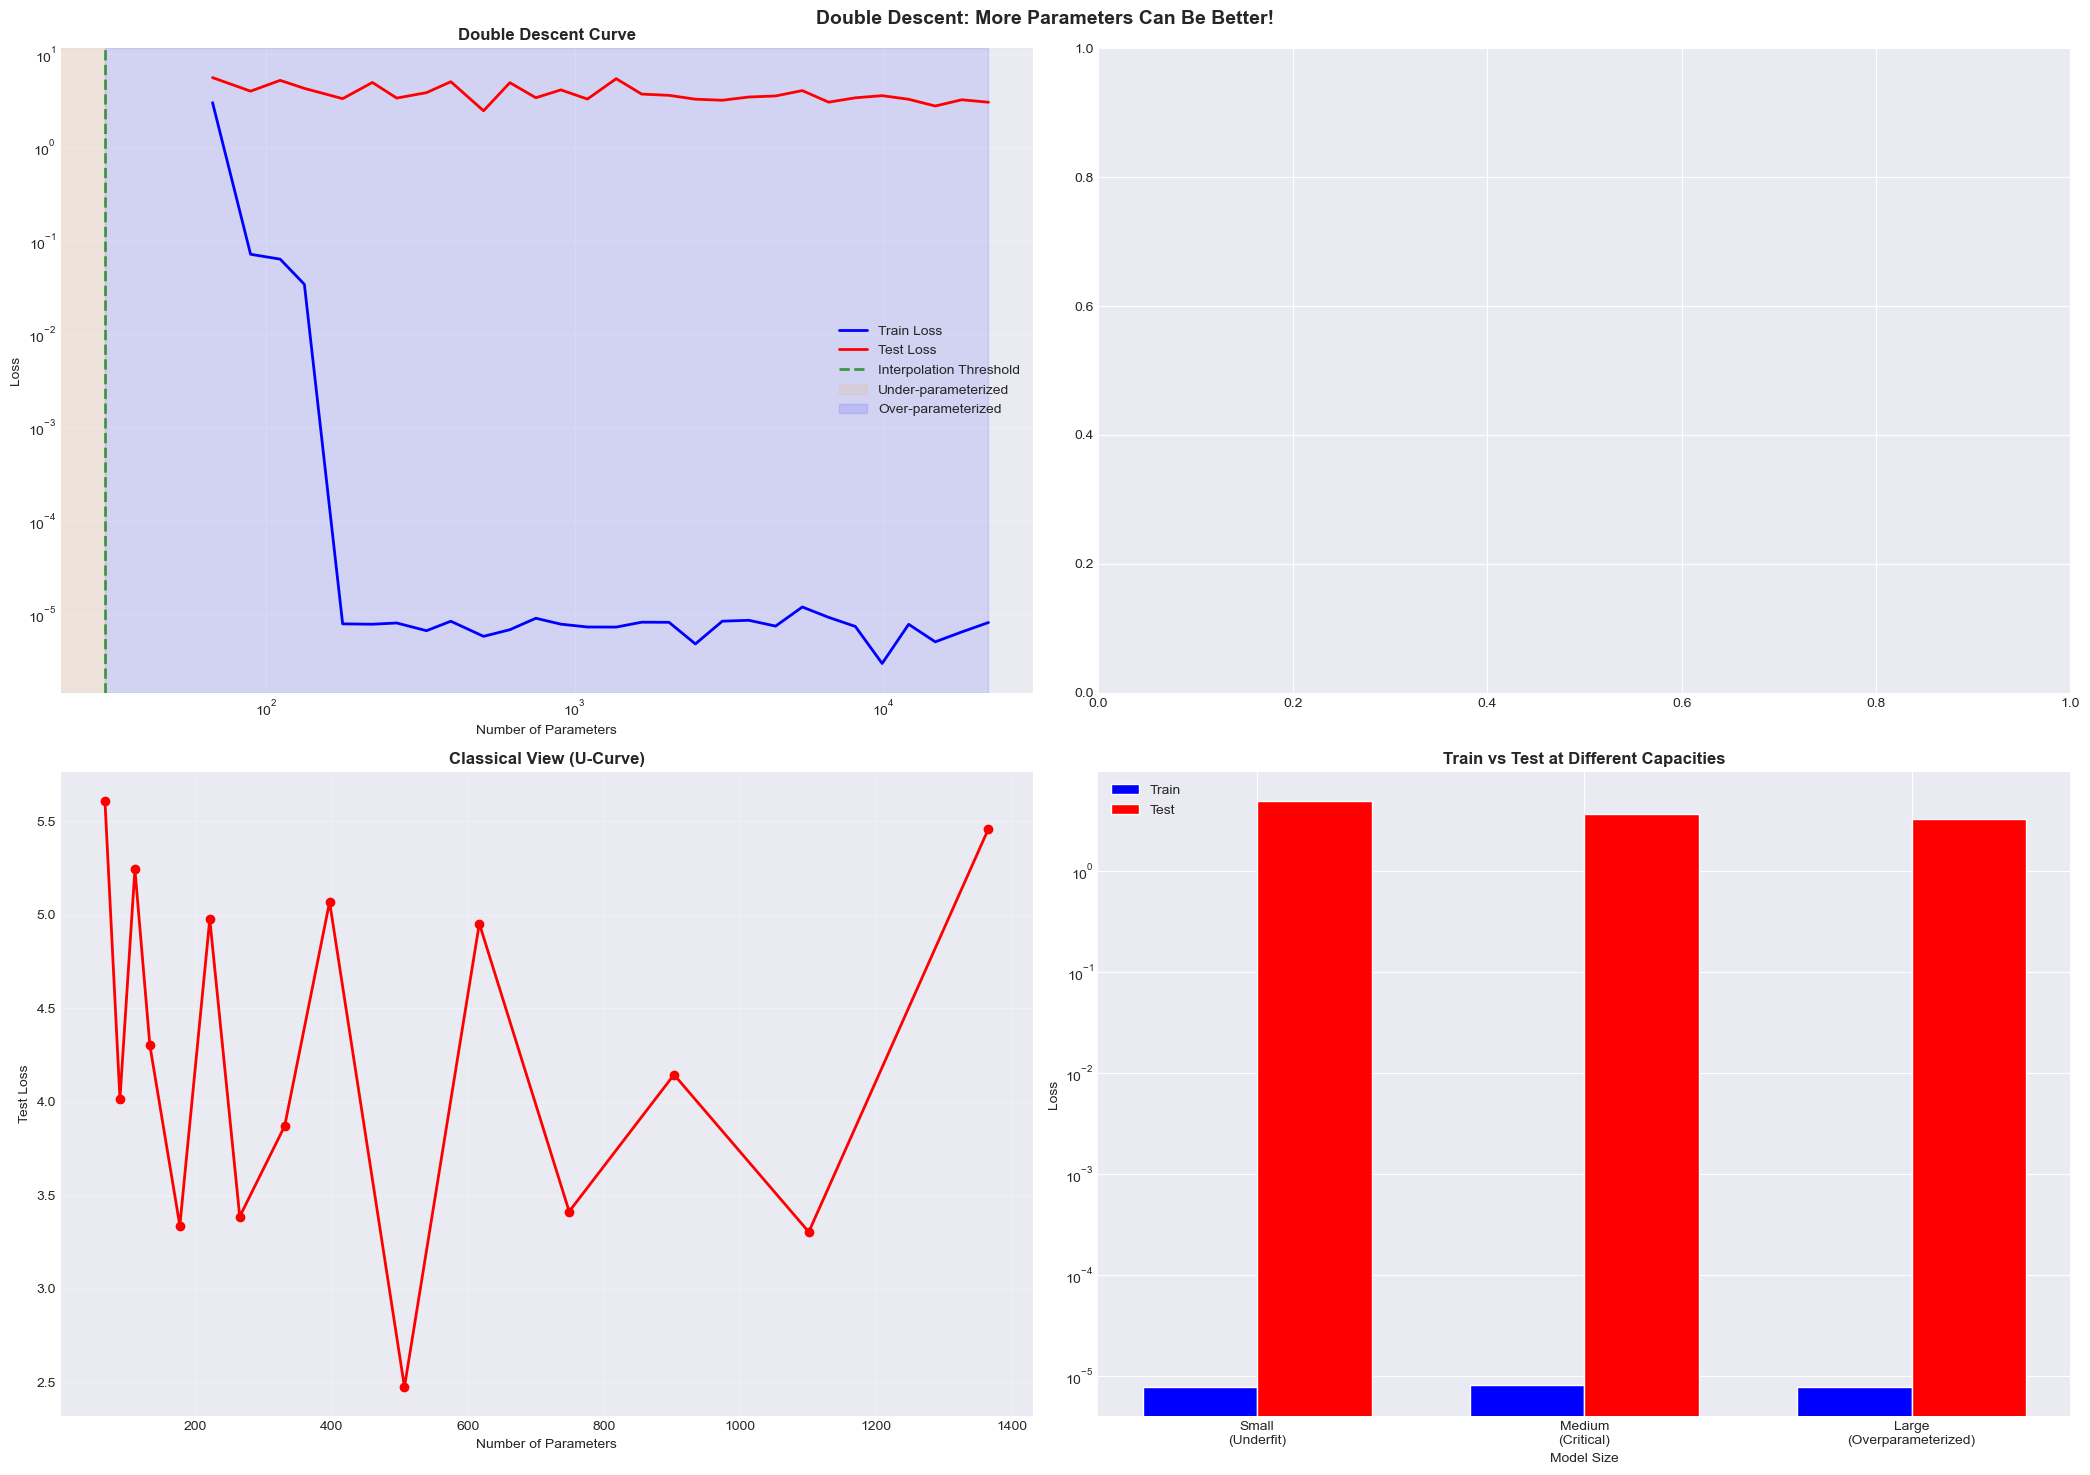


💡 Key observations:
1. Test error first decreases (classical regime)
2. Then increases near interpolation threshold
3. Then decreases again (modern regime)
4. Best performance often in overparameterized regime!


In [18]:
demo_double_descent()


In [19]:
# %% [markdown]
# info loss landscape visualization

# %%
def demo_loss_landscape():
    """
    info visualize loss landscapes and optimization trajectories
    """

    # info create a simple 2-layer network for visualization
    class SimpleNet(nn.Module):
        def __init__(self, width=10):
            super().__init__()
            self.fc1 = nn.Linear(2, width)
            self.fc2 = nn.Linear(width, 1)

        def forward(self, x):
            return self.fc2(torch.relu(self.fc1(x)))

    # info generate simple classification data
    np.random.seed(42)
    X = np.random.randn(100, 2).astype(np.float32)
    y = (X[:, 0] * X[:, 1] > 0).astype(np.float32).reshape(-1, 1)

    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)

    # info train models with different widths
    widths = [2, 10, 50]
    models = {}

    for width in widths:
        model = SimpleNet(width)
        optimizer = optim.SGD(model.parameters(), lr=0.1)

        for _ in range(100):
            pred = torch.sigmoid(model(X_tensor))
            loss = F.binary_cross_entropy(pred, y_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        models[width] = model

    # info visualize loss landscapes
    def get_loss_landscape_2d(model, X, y, param1_idx=0, param2_idx=1):
        """info get 2D loss landscape by varying two parameters"""

        # info get current parameters
        params = []
        for p in model.parameters():
            params.append(p.data.clone())

        # info flatten parameters
        flat_params = torch.cat([p.flatten() for p in params])
        n_params = len(flat_params)

        # info choose two random directions
        if n_params < 2:
            return None, None, None

        #info create perturbation directions
        dir1 = torch.randn(n_params)
        dir1 = dir1 / dir1.norm()
        dir2 = torch.randn(n_params)
        dir2 = dir2 - (dir2.dot(dir1)) * dir1  # Orthogonalize
        dir2 = dir2 / dir2.norm()

        # info create grid
        alpha_range = np.linspace(-2, 2, 50)
        beta_range = np.linspace(-2, 2, 50)

        loss_surface = np.zeros((50, 50))

        for i, alpha in enumerate(alpha_range):
            for j, beta in enumerate(beta_range):
                # Perturb parameters
                perturbed = flat_params + alpha * dir1 + beta * dir2

                # info reshape and set to model
                idx = 0
                for p in model.parameters():
                    p_shape = p.shape
                    p_size = p.numel()
                    p.data = perturbed[idx:idx+p_size].reshape(p_shape)
                    idx += p_size

                # info compute loss
                with torch.no_grad():
                    pred = torch.sigmoid(model(X_tensor))
                    loss = F.binary_cross_entropy(pred, y_tensor)
                    loss_surface[i, j] = loss.item()

        # info restore original parameters
        idx = 0
        for p, orig_p in zip(model.parameters(), params):
            p.data = orig_p

        return alpha_range, beta_range, loss_surface

    # info visualization
    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # info loss landscapes for different widths
    for idx, width in enumerate(widths):
        # 3D surface
        ax = fig.add_subplot(gs[0, idx], projection='3d')

        alpha_range, beta_range, loss_surface = get_loss_landscape_2d(models[width], X, y)

        if loss_surface is not None:
            A, B = np.meshgrid(alpha_range, beta_range)

            surf = ax.plot_surface(A, B, loss_surface.T, cmap='viridis',
                                  alpha=0.8, edgecolor='none')

            ax.set_xlabel('Direction 1')
            ax.set_ylabel('Direction 2')
            ax.set_zlabel('Loss')
            ax.set_title(f'Width {width} (3D)', fontweight='bold')
            ax.view_init(elev=30, azim=45)

        # info contour plot
        ax = fig.add_subplot(gs[1, idx])

        if loss_surface is not None:
            contour = ax.contour(alpha_range, beta_range, loss_surface.T,
                                levels=20, cmap='viridis')
            ax.clabel(contour, inline=True, fontsize=8)
            ax.set_xlabel('Direction 1')
            ax.set_ylabel('Direction 2')
            ax.set_title(f'Width {width} (Contour)', fontweight='bold')
            ax.grid(True, alpha=0.3)

        # 1D slice
        ax = fig.add_subplot(gs[2, idx])

        if loss_surface is not None:
            # Take slice through middle
            middle_idx = len(alpha_range) // 2
            slice_1d = loss_surface[:, middle_idx]

            ax.plot(alpha_range, slice_1d, linewidth=2)
            ax.set_xlabel('Distance from Minimum')
            ax.set_ylabel('Loss')
            ax.set_title(f'Width {width} (1D Slice)', fontweight='bold')
            ax.grid(True, alpha=0.3)

            # info mark sharpness
            sharpness = np.diff(slice_1d, 2).mean()
            ax.text(0.5, 0.9, f'Sharpness: {abs(sharpness):.3f}',
                   transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='wheat'))

    plt.suptitle('Loss Landscape Visualization: Wider Networks → Smoother Landscapes',
                fontsize=14, fontweight='bold')
    plt.show()

    # info mode connectivity visualization
    print("\nTesting mode connectivity...")

    # info train two models from different initializations
    model1 = SimpleNet(50)
    model2 = SimpleNet(50)

    for model in [model1, model2]:
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        for _ in range(200):
            pred = torch.sigmoid(model(X_tensor))
            loss = F.binary_cross_entropy(pred, y_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # info interpolate between models
    alphas = np.linspace(0, 1, 50)
    interpolated_losses = []

    for alpha in alphas:
        # info linear interpolation
        for p1, p2 in zip(model1.parameters(), model2.parameters()):
            p_interp = (1 - alpha) * p1.data + alpha * p2.data

        # info create interpolated model
        model_interp = SimpleNet(50)
        for p_interp, p1, p2 in zip(model_interp.parameters(),
                                    model1.parameters(),
                                    model2.parameters()):
            p_interp.data = (1 - alpha) * p1.data + alpha * p2.data

        # info compute loss
        with torch.no_grad():
            pred = torch.sigmoid(model_interp(X_tensor))
            loss = F.binary_cross_entropy(pred, y_tensor)
            interpolated_losses.append(loss.item())

    # info plot mode connectivity
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(alphas, interpolated_losses, 'b-', linewidth=3)
    ax.scatter([0, 1], [interpolated_losses[0], interpolated_losses[-1]],
              color='red', s=100, zorder=5)
    ax.set_xlabel('Interpolation α')
    ax.set_ylabel('Loss')
    ax.set_title('Mode Connectivity: Path Between Two Solutions', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # info add annotations
    ax.annotate('Model 1', (0, interpolated_losses[0]),
               xytext=(-0.1, interpolated_losses[0] + 0.01),
               fontsize=10, fontweight='bold')
    ax.annotate('Model 2', (1, interpolated_losses[-1]),
               xytext=(1.02, interpolated_losses[-1]),
               fontsize=10, fontweight='bold')

    barrier = max(interpolated_losses) - min([interpolated_losses[0], interpolated_losses[-1]])
    ax.text(0.5, 0.9, f'Barrier Height: {barrier:.3f}',
           transform=ax.transAxes, ha='center',
           bbox=dict(boxstyle='round', facecolor='wheat'),
           fontsize=11, fontweight='bold')

    plt.show()

    print("\n💡 Key insights:")
    print("1. Wider networks have smoother loss landscapes")
    print("2. Multiple good solutions exist (different minima)")
    print("3. Solutions are often connected (mode connectivity)")
    print("4. Flat minima generalize better than sharp minima")


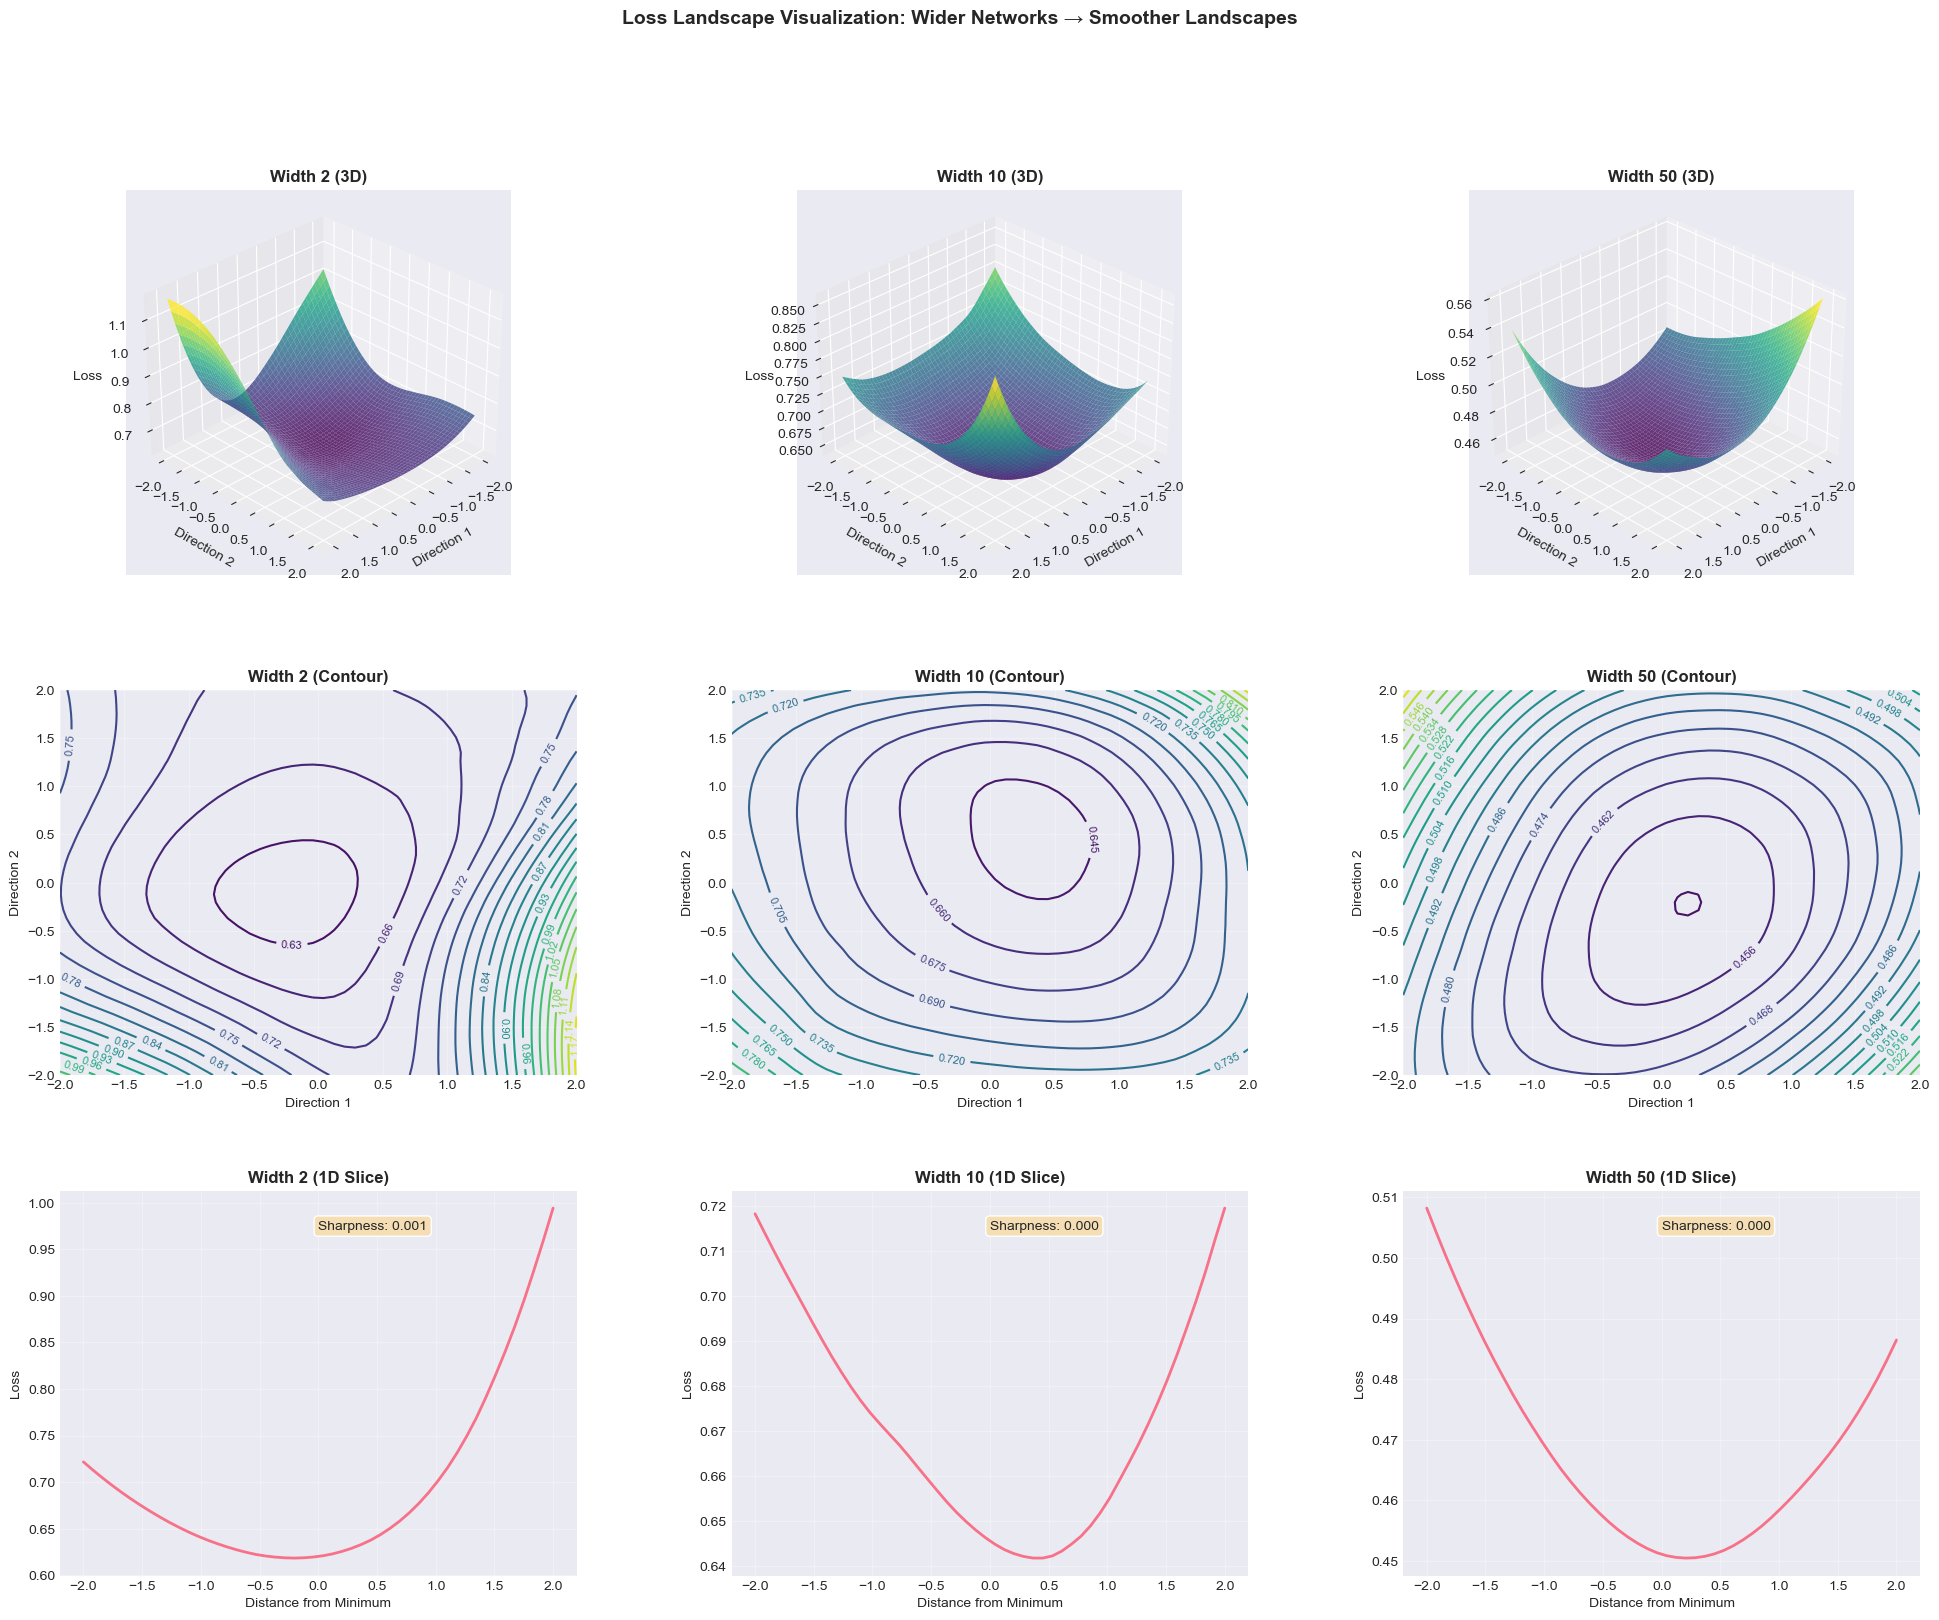


Testing mode connectivity...


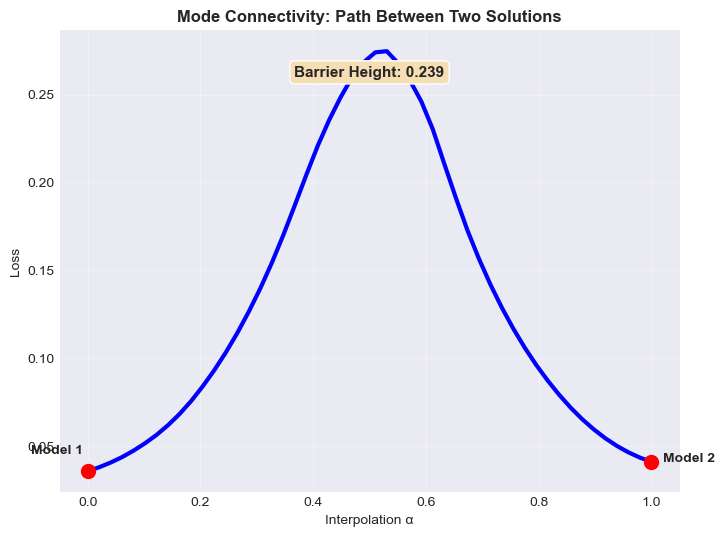


💡 Key insights:
1. Wider networks have smoother loss landscapes
2. Multiple good solutions exist (different minima)
3. Solutions are often connected (mode connectivity)
4. Flat minima generalize better than sharp minima


In [20]:
demo_loss_landscape()


In [ ]:
# %%
print("\n" + "="*60)
print("✅ All demonstrations complete!")
print("="*60)
print("\nKey takeaways from all demos:")
print("1. Deep learning works because of automatic feature learning")
print("2. Overparameterization helps optimization, not just capacity")
print("3. Foundation models amortize learning across tasks")
print("4. Modern optimizers adapt to the loss landscape")
print("5. Networks prefer to learn patterns over memorization")
print("6. Double descent shows more can be better")
print("7. Loss landscapes reveal why deep learning works")
print("\n🎯 Ready for your lecture!")
print("="*60)